## Exploratory data analysis: lobbying

In [3]:
import numpy as np
import pandas as pd
import datetime
import ast
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
from importlib import reload

## Sorting by lobbying issue code

To properly start looking at the lobbying data, we need to understand the lobbying codes and sort by them. Here is a dictionary called `issue_codes` relating the issue codes appearing in the lobbying filings to their meanings - it's lifted from https://lda.congress.gov/ld/help/default.htm?turl=Documents%2FAppCodes.htm.

In [22]:
issue_codes={
    'ACC': 'Accounting',
    'ADV': 'Advertising',
    'AER': 'Aerospace',
    'AGR': 'Agriculture',
    'ALC': 'Alcohol & Drug Abuse',
    'ANI': 'Animals',
    'APP': 'Apparel/Clothing Industry/Textiles',
    'ART': 'Arts/Entertainment',
    'AUT': 'Automotive Industry',
    'AVI': 'Aviation/Aircraft/Airlines',
    'BAN': 'Banking',
    'BNK': 'Bankruptcy',
    'BEV': 'Beverage Industry',
    'BUD': 'Budget/Appropriations',
    'CAW': 'Clean Air & Water (Quality)',
    'CDT': 'Commodities (Big Ticket)',
    'CHM': 'Chemicals/Chemical Industry',
    'CIV': 'Civil Rights/Civil Liberties',
    'COM': 'Communications/Broadcasting/Radio/TV',
    'CPI': 'Computer Industry',
    'CSP': 'Consumer Issues/Safety/Protection',
    'CON': 'Constitution',
    'CPT': 'Copyright/Patent/Trademark',
    'DEF': 'Defense',
    'DOC': 'District of Columbia',
    'DIS': 'Disaster Planning/Emergencies',
    'ECN': 'Economics/Economic Development',
    'EDU': 'Education',
    'ENG': 'Energy/Nuclear',
    'ENV': 'Environmental/Superfund',
    'FAM': 'Family Issues/Abortion/Adoption',
    'FIR': 'Firearms/Guns/Ammunition',
    'FIN': 'Financial Institutions/Investments/Securities',
    'FOO': 'Food Industry (Safety, Labeling, etc.)',
    'FOR': 'Foreign Relations',
    'FUE': 'Fuel/Gas/Oil',
    'GAM': 'Gaming/Gambling/Casino',
    'GOV': 'Government Issues',
    'HCR': 'Health Issues',
    'HOM': 'Homeland Security',
    'HOU': 'Housing',
    'IMM': 'Immigration',
    'IND': 'Indian/Native American Affairs',
    'INS': 'Insurance',
    'LBR': 'Labor Issues/Antitrust/Workplace',
    'INT': 'Intelligence and Surveillance',
    'LAW': 'Law Enforcement/Crime/Criminal Justice',
    'MAN': 'Manufacturing',
    'MAR': 'Marine/Maritime/Boating/Fisheries',
    'MED': 'Medical/Disease Research/Clinical Labs',
    'MIA': 'Media (Information/Publishing)',
    'MMM': 'Medicare/Medicaid',
    'MON': 'Minting/Money/Gold Standard',
    'NAT': 'Natural Resources',
    'PHA': 'Pharmacy',
    'POS': 'Postal',
    'RRR': 'Railroads',
    'RES': 'Real Estate/Land Use/Conservation',
    'REL': 'Religion',
    'RET': 'Retirement',
    'ROD': 'Roads/Highway',
    'SCI': 'Science/Technology',
    'SMB': 'Small Business',
    'SPO': 'Sports/Athletics',
    'TAR': 'Miscellaneous Tariff Bills',
    'TAX': 'Taxation/Internal Revenue Code',
    'TEC': 'Telecommunications',
    'TOB': 'Tobacco',
    'TOR': 'Torts',
    'TRD': 'Trade (Domestic & Foreign)',
    'TRA': 'Transportation',
    'TOU': 'Travel/Tourism',
    'TRU': 'Trucking/Shipping',
    'URB': 'Urban Development/Municipalities',
    'UNM': 'Unemployment',
    'UTI': 'Utilities',
    'VET': 'Veterans',
    'WAS': 'Waste (hazardous/solid/interstate/nuclear)',
    'WEL': 'Welfare'
}

Compare this to the sector breakdown Paul attached to the stock data.

In [89]:
sectors=list(pd.read_csv("trading_data/stock_sectors.csv", header=None)[0]).remove('Not Found')

In [58]:
sectors

['Advertising Agencies',
 'Aerospace & Defense',
 'Agricultural Inputs',
 'Airlines',
 'Airports & Air Services',
 'Aluminum',
 'Apparel Manufacturing',
 'Apparel Retail',
 'Asset Management',
 'Auto & Truck Dealerships',
 'Auto Manufacturers',
 'Auto Parts',
 'Banks - Diversified',
 'Banks - Regional',
 'Beverages - Brewers',
 'Beverages - Non-Alcoholic',
 'Beverages - Wineries & Distilleries',
 'Biotechnology',
 'Broadcasting',
 'Building Materials',
 'Building Products & Equipment',
 'Business Equipment & Supplies',
 'Capital Markets',
 'Chemicals',
 'Coking Coal',
 'Communication Equipment',
 'Computer Hardware',
 'Confectioners',
 'Conglomerates',
 'Consulting Services',
 'Consumer Electronics',
 'Copper',
 'Credit Services',
 'Department Stores',
 'Diagnostics & Research',
 'Discount Stores',
 'Drug Manufacturers - General',
 'Drug Manufacturers - Specialty & Generic',
 'Education & Training Services',
 'Electrical Equipment & Parts',
 'Electronic Components',
 'Electronic Gaming

This comparison is by no means one-to-one. However, there are definitely some lobbying issue codes that strongly match a portfolio of industry sectors. Paul did a bit of matching codes to one another - it's in `./trading_data/sector2lobbyingcode.csv`. I'll use it in a second.

No matter what though, we should start by breaking down the data by issue codes. First, we can keep track of filing period by returning the appropriate start and end date.

In [58]:
def filing_period_start(year,quarter):
    if quarter=='1':
        start= datetime.date(year=year, month=1, day=1)
    if quarter=='2':
        start= datetime.date(year=year, month=4, day=1)
    if quarter=='3':
        start= datetime.date(year=year, month=7, day=1)
    if quarter=='4':
        start= datetime.date(year=year, month=10, day=1)
    return start

def filing_period_end(year,quarter):
    if quarter=='1':
        d= datetime.date(year=year, month=3, day=31)
    if quarter=='2':
        d= datetime.date(year=year, month=6, day=30)
    if quarter=='3':
        d= datetime.date(year=year, month=9, day=30)
    if quarter=='4':
        d= datetime.date(year=year, month=12, day=31)
    return d


In [60]:
years=range(2013,2024) # I omit the 2024 data for now - maybe we redownload this and clean it, since it must have been updated by now to include a full reporting of Q1 information.
quarters=[str(i) for i in range(1,5)]
lobbying=pd.DataFrame()
for year in years:
    for quarter in quarters:
        df=pd.read_csv("lobbying_data/by_quarter/filings_"+str(year)+"Q"+quarter+".csv")
        df['period_start']=filing_period_start(year, quarter)
        df['period_end']=filing_period_end(year, quarter)
        lobbying=pd.concat([lobbying, df])

Let me export this as a single file, so that in the future we don't have to load in the lobbying data one quarter or issue code at a time.

In [62]:
lobbying.to_csv("lobbying_data/filings_all.csv", index=False)

In [63]:
lobbying.info()

<class 'pandas.core.frame.DataFrame'>
Index: 810672 entries, 0 to 21600
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   registrant                810672 non-null  object 
 1   client                    810672 non-null  object 
 2   income                    810672 non-null  float64
 3   expenses                  810672 non-null  float64
 4   issue_codes               810672 non-null  object 
 5   entities_lobbied          810672 non-null  object 
 6   lobbying_description      810672 non-null  object 
 7   foreign_entities          810672 non-null  object 
 8   affiliated_organizations  810672 non-null  object 
 9   JACK_conviction           810672 non-null  bool   
 10  filing_uuid               810672 non-null  object 
 11  filing_type               810672 non-null  object 
 12  expenses_method           810672 non-null  object 
 13  dt_posted                 810672 non-null  object 

When we sort by issue code, we will ignore all filings with no attached codes.

In [18]:
no_codes=lobbying.loc[lobbying.issue_codes=="[]"].copy()

In [19]:
no_codes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116082 entries, 2 to 21599
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   registrant                116082 non-null  object 
 1   client                    116082 non-null  object 
 2   income                    116082 non-null  float64
 3   expenses                  116082 non-null  float64
 4   issue_codes               116082 non-null  object 
 5   entities_lobbied          116082 non-null  object 
 6   lobbying_description      116082 non-null  object 
 7   foreign_entities          116082 non-null  object 
 8   affiliated_organizations  116082 non-null  object 
 9   JACK_conviction           116082 non-null  bool   
 10  filing_uuid               116082 non-null  object 
 11  filing_type               116082 non-null  object 
 12  expenses_method           116082 non-null  object 
 13  dt_posted                 116082 non-null  object 

It's about $1/8$ of the total filings! How much is it by spending?

In [65]:
spending=np.sum(lobbying['expenses'])+np.sum(lobbying['income'])
spending_no_codes=np.sum(no_codes['expenses'])+np.sum(no_codes['income'])
print(spending_no_codes/spending)

0.010480280681845748


It's only around 1% of total spending. I don't feel too bad about ignoring this then.

In [21]:
only_codes=pd.concat([lobbying,no_codes]).drop_duplicates(keep=False)

In [30]:
only_codes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 694590 entries, 0 to 21600
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   registrant                694590 non-null  object 
 1   client                    694590 non-null  object 
 2   income                    694590 non-null  float64
 3   expenses                  694590 non-null  float64
 4   issue_codes               694590 non-null  object 
 5   entities_lobbied          694590 non-null  object 
 6   lobbying_description      694590 non-null  object 
 7   foreign_entities          694590 non-null  object 
 8   affiliated_organizations  694590 non-null  object 
 9   JACK_conviction           694590 non-null  bool   
 10  filing_uuid               694590 non-null  object 
 11  filing_type               694590 non-null  object 
 12  expenses_method           694590 non-null  object 
 13  dt_posted                 694590 non-null  object 

In [32]:
issue_list=[ast.literal_eval(only_codes.iloc[i]['issue_codes']) for i in range(len(only_codes))]

In [33]:
only_codes['issue_codes']=issue_list

In [37]:

in_bool=[('ACC' in only_codes.iloc[i]['issue_codes']) for i in range(len(only_codes))]

In [38]:
only_codes.loc[in_bool]

,registrant,client,income,expenses,issue_codes,entities_lobbied,lobbying_description,foreign_entities,affiliated_organizations,JACK_conviction,filing_uuid,filing_type,expenses_method,dt_posted,reg_id,cl_id,period_start,period_end
430,CHS INC.,"CHS, INC",0.0,40000.00,"[ACC, ENG, BAN, AGR, TRA, TAX]","['HOUSE OF REPRESENTATIVES', 'SENATE']","['LIFO', 'RIN issue', 'End user use of derivat...",[],[],False,9095f6ef-3754-4f12-a794-af4598c36598,Q1,a,2013-04-04 14:58:54.537,286451,176515,2013-01-01,2013-03-31
443,"THE VELASQUEZ GROUP, L.L.C.",KPMG LLP,80000.0,0.00,[ACC],"['HOUSE OF REPRESENTATIVES', 'SENATE']",['Monitoring for would be legislative provisio...,[],[],False,caf4965d-4c2b-4376-b06f-d90a28cb0671,Q1,0,2013-04-04 20:34:21.480,53403,158245,2013-01-01,2013-03-31
619,UNIVERSITY OF IOWA,UNIVERSITY OF IOWA,0.0,29312.86,"[BAN, ENV, SPO, ACC, GOV, ROD, UTI, AGR, WAS, ...","['Agriculture, Dept of (USDA)', 'Centers For M...",['Implementation of the Higher Education Act a...,[],[],False,d15d1944-6d6b-4b94-9a3c-4cc502798711,Q1,a,2013-04-08 11:14:59.307,49191,156117,2013-01-01,2013-03-31
986,DALY CONSULTING GROUP,PWC US GROUP LLP (FORMERLY PRICEWATERHOUSECOOP...,45000.0,0.00,[ACC],"['HOUSE OF REPRESENTATIVES', 'SENATE', 'Securi...",['Issues related to the accounting profession.'],[],[],False,44ae954d-4525-49fe-8142-db98c67b3511,Q1,0,2013-04-09 17:27:14.800,400923683,196221,2013-01-01,2013-03-31
999,JULEANNA GLOVER,AICPA,15000.0,0.00,[ACC],['HOUSE OF REPRESENTATIVES'],['Mobile Workforce Act'],[],[],False,5712e1a9-4612-4774-a421-b235dfc8e46a,Q1,0,2013-04-09 18:23:24.117,298934,180103,2013-01-01,2013-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20182,MARKQUEST,MARKQUEST,0.0,1.00,"[TAX, ACC, FOO, BEV, DEF]","['Army, Dept of (Other)', 'Defense Commissary ...","['business expenses', 'how to treat business e...",[],[],False,57b46505-bf3b-497a-9e3a-cbf585c60c1a,Q4,A,2024-01-31 12:18:13,65932,162929,2023-10-01,2023-12-31
20185,MARKQUEST,KASICH COMPANY,1.0,0.00,"[TAX, SMB, ACC]","['HOUSE OF REPRESENTATIVES', 'SENATE']","['tax relief for business', 'business relief',...",[],[],False,f1a4db02-61e9-4ca7-9fe5-45ffcb6e47d9,Q4,0,2024-01-31 12:22:27,65932,204573,2023-10-01,2023-12-31
20506,THE WILLIAMS GROUP,FINANCIAL ACCOUNTING FOUNDATION,45000.0,0.00,[ACC],"['HOUSE OF REPRESENTATIVES', 'SENATE', 'Securi...",['Issues relating to the formulation and devel...,[],[],False,6f552393-10cc-4577-b5d5-96f9dfa63446,Q4,0,2024-02-05 12:36:53,401104049,54899,2023-10-01,2023-12-31
20652,THE DLM GROUP,"GENESIS HEALTH CARE, INC.",15000.0,0.00,"[MED, ALC, ACC, HCR, MMM]","['HOUSE OF REPRESENTATIVES', 'Health & Human S...","['no activity', 'Substance abuse funding', 'An...",[],[],False,e8b4951b-7b6e-454c-bc35-05a359bd2b7e,Q4,0,2024-02-05 13:13:13,313794,184703,2023-10-01,2023-12-31


Here, let me export the filings broken up in this way.

In [43]:
for issue in issue_codes.keys():
    issue_bool=[(issue in only_codes.iloc[i]['issue_codes']) for i in range(len(only_codes))]
    lobbying_issue=only_codes.loc[issue_bool].copy()
    lobbying_issue.to_csv("lobbying_data/by_issue_code/filings_"+issue+".csv", index=False)

In [92]:
summary=pd.DataFrame()
for issue in issue_codes.keys():
    issue_bool=[(issue in only_codes.iloc[i]['issue_codes']) for i in range(len(only_codes))]
    lobbying_issue=only_codes.loc[issue_bool].copy()
    lobbying_issue['spending']=lobbying_issue['expenses']+lobbying_issue['income']
    spending_per_quarter=lobbying_issue.groupby(['period_start']).spending.sum()
    summary[issue]=spending_per_quarter

And we export it.

In [99]:
summary.to_csv("lobbying_data/lobbying_totals.csv")

In [ ]:
for issue in issue_codes.keys():
    plt.figure(figsize=(5,5))
    plt.title("Lobbying for "+issue_codes[issue])
    plt.plot(summary.index, summary[issue])
    plt.xlabel("Quarter (start date)")
    plt.ylabel(issue+" Spending (USD)")


In [131]:
sec2issue=pd.read_csv("trading_data/sector2lobbyingcode.csv",header=None)
sec2issue.columns=['stock_sector', 'issue_code_1', 'issue_code_2', 'issue_code_3']
sec2issue=sec2issue.fillna(0)

In [152]:
sec2issue=pd.read_csv("trading_data/sector2lobbyingcode.csv", header=None).fillna(0)
sec2issue.columns=['sector', 'code1', 'code2', 'code3']

In [153]:
sec2issue

,sector,code1,code2,code3
0,Advertising Agencies,ADV,0,0
1,Aerospace & Defense,AER,DEF,0
2,Agricultural Inputs,AGR,0,0
3,Airlines,AER,TRA,TOU
4,Airports & Air Services,AER,TRA,TOU
...,...,...,...,...
141,Utilities - Regulated Electric,UTI,ENG,0
142,Utilities - Regulated Gas,UTI,ENG,FUE
143,Utilities - Regulated Water,UTI,0,0
144,Utilities - Renewable,UTI,0,0


In [161]:
one_code=sec2issue.loc[(sec2issue.code2==0) &  (sec2issue.code3==0) & (sec2issue.code1 !=0)]

In [178]:
codes=list(set(one_code['code1'].values))
codes.sort()
codes

['ADV',
 'AGR',
 'APP',
 'ART',
 'AUT',
 'BEV',
 'CHM',
 'CPI',
 'EDU',
 'ENG',
 'FIN',
 'FOO',
 'GAM',
 'HCR',
 'INS',
 'LBR',
 'MAN',
 'NAT',
 'PHA',
 'RES',
 'RRR',
 'SCI',
 'TEC',
 'TOB',
 'TRU',
 'UTI',
 'WAS']

In [179]:
for code in codes:
    print( "'"+code+"'" + " : ", list(one_code.loc[one_code.code1==code]['sector']))

'ADV' :  ['Advertising Agencies']
'AGR' :  ['Agricultural Inputs', 'Farm & Heavy Construction Machinery', 'Farm Products']
'APP' :  ['Apparel Manufacturing', 'Apparel Retail', 'Department Stores', 'Discount Stores', 'Footwear & Accessories', 'Luxury Goods']
'ART' :  ['Electronic Gaming & Multimedia', 'Entertainment', 'Publishing']
'AUT' :  ['Auto & Truck Dealerships', 'Auto Manufacturers', 'Auto Parts', 'Recreational Vehicles']
'BEV' :  ['Beverages - Brewers', 'Beverages - Non-Alcoholic', 'Beverages - Wineries & Distilleries']
'CHM' :  ['Chemicals', 'Specialty Chemicals']
'CPI' :  ['Computer Hardware', 'Consumer Electronics', 'Electronics & Computer Distribution', 'Information Technology Services', 'Software - Application', 'Software - Infrastructure']
'EDU' :  ['Education & Training Services']
'ENG' :  ['Solar']
'FIN' :  ['Asset Management', 'Capital Markets', 'Financial Conglomerates', 'Financial Data & Stock Exchanges']
'FOO' :  ['Confectioners', 'Food Distribution', 'Packaged Foods

In [136]:
sec_one_code=sec2issue.loc[(sec2issue.issue_code_2==0) & (sec2issue.issue_code_3==0)].copy()


OK, here is a first list of codes to look at.

In [9]:
cognates={'ADV' :  ['Advertising Agencies'],
          'BEV' :  ['Beverages - Brewers', 'Beverages - Non-Alcoholic', 'Beverages - Wineries & Distilleries'], 
          'CHM' :  ['Chemicals', 'Specialty Chemicals'], 
          'FOO' :  ['Confectioners', 'Food Distribution', 'Packaged Foods'],
          'GAM' :  ['Gambling'],
          'INS' :  ['Insurance - Diversified', 'Insurance - Life', 'Insurance - Property & Casualty', 'Insurance - Reinsurance', 'Insurance - Specialty', 'Insurance Brokers'],
          'PHA' :  ['Drug Manufacturers - General', 'Drug Manufacturers - Specialty & Generic', 'Pharmaceutical Retailers'],
          'RES' :  ['REIT - Diversified', 'REIT - Industrial', 'REIT - Mortgage', 'REIT - Office', 'REIT - Specialty', 'Real Estate - Development', 'Real Estate - Diversified', 'Real Estate Services'],
          'TOB' :  ['Tobacco'],
          'TEC' :  ['Telecom Services'],
          'UTI' :  ['Utilities - Diversified', 'Utilities - Independent Power Producers', 'Utilities - Regulated Water', 'Utilities - Renewable'] }

To these, I want to manually add some codes that were excluded by the `one_code` game I was playing above.

In [10]:
cognates['FUE']=['Oil & Gas Drilling', 'Oil & Gas E&P','Oil & Gas Equipment & Services', 'Oil & Gas Integrated', 'Oil & Gas Midstream', 'Oil & Gas Refining & Marketing']
cognates['DEF']=['Aerospace & Defense']

I'm going to take a second and look at the filings with the `'AER'` issue code, and try to identify how many of these both do not have the `'DEF'` issue code, but do mention defense in their description.

In [38]:
aero=pd.read_csv("lobbying_data/by_issue_code/filings_AER.csv")
defen=pd.read_csv("lobbying_data/by_issue_code/filings_DEF.csv")

In [43]:
aero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6320 entries, 0 to 6319
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   registrant                6320 non-null   object 
 1   client                    6320 non-null   object 
 2   income                    6320 non-null   float64
 3   expenses                  6320 non-null   float64
 4   issue_codes               6320 non-null   object 
 5   entities_lobbied          6320 non-null   object 
 6   lobbying_description      6320 non-null   object 
 7   foreign_entities          6320 non-null   object 
 8   affiliated_organizations  6320 non-null   object 
 9   JACK_conviction           6320 non-null   bool   
 10  filing_uuid               6320 non-null   object 
 11  filing_type               6320 non-null   object 
 12  expenses_method           6320 non-null   object 
 13  dt_posted                 6320 non-null   object 
 14  reg_id  

In [40]:
aero_no_defen=pd.concat([aero,defen,defen]).drop_duplicates(keep=False)

In [42]:
aero_no_defen

,registrant,client,income,expenses,issue_codes,entities_lobbied,lobbying_description,foreign_entities,affiliated_organizations,JACK_conviction,filing_uuid,filing_type,expenses_method,dt_posted,reg_id,cl_id,period_start,period_end
0,"GEOEYE, INC.","GEOEYE, INC.",0.0,7000.0,['AER'],"['HOUSE OF REPRESENTATIVES', 'SENATE', 'White ...",['Support for US commercial satellite imagery ...,[],[],False,46e4def4-29fc-4e5e-80ae-fc4bdd77c7f8,1T,a,2013-01-30 18:42:54.060,400276319,188822,2013-01-01,2013-03-31
1,SONNY CALLAHAN AND ASSOCIATES,"CITY OF PENSACOLA, FLORIDA",12000.0,0.0,['AER'],"['HOUSE OF REPRESENTATIVES', 'SENATE', 'Transp...","['Liaison with Baldwin County, AL officials, U...",[],[],False,03567205-0d7e-49e7-be82-baedf479682b,Q1,0,2013-04-02 13:30:11.623,81338,171165,2013-01-01,2013-03-31
2,"PARKER, POE, ADAMS & BERNSTEIN LLP","FUENTEK, LLC",1.0,0.0,['AER'],['Natl Aeronautics & Space Administration (NAS...,['Representation regarding support for NASA ap...,[],[],False,20703519-7772-475d-a0ca-e44c2e0a1984,Q1,0,2013-04-02 14:48:29.623,288098,177061,2013-01-01,2013-03-31
3,"NATIONAL GROUP, LLP",ITHACA COLLEGE,20000.0,0.0,"['AER', 'TRA', 'HCR']","['HOUSE OF REPRESENTATIVES', 'Natl Aeronautics...","['Research Funding', 'Highway Funding', 'Resea...",[],[],False,956bad7f-fc80-4a6a-931d-fe75a77cfad6,Q1,0,2013-04-04 10:41:10.777,66090,163279,2013-01-01,2013-03-31
4,"NATIONAL GROUP, LLP",SEA ORBITER,40000.0,0.0,['AER'],['Natl Aeronautics & Space Administration (NAS...,['NASA'],[],[],False,c159aa88-2d62-4c91-8197-834025a0f746,Q1,0,2013-04-04 10:50:20.370,66090,163283,2013-01-01,2013-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6311,IKYR LLC,ADVANCED SPACE LLC,20000.0,0.0,['AER'],"['Defense, Dept of (DOD)', 'HOUSE OF REPRESENT...",['Defense Appropriations and authorization'],[],[],False,8b66d49a-dd96-4bfb-863e-4001ace6e513,Q4,0,2024-02-06 11:18:09,401106952,53773,2023-10-01,2023-12-31
6312,IKYR LLC,COGNITIVE SPACE,1.0,0.0,['AER'],"['HOUSE OF REPRESENTATIVES', 'SENATE']","['Artificial Intelligence, NASA, USSF']",[],[],False,d7349f70-e0fd-478a-a939-45cd6de3cdf5,Q4,0,2024-02-06 11:21:33,401106952,58539,2023-10-01,2023-12-31
6313,IKYR LLC,LOFT FEDERAL,1.0,0.0,['AER'],"['HOUSE OF REPRESENTATIVES', 'SENATE']","['NASA, USSF, Space Development Agency']",[],[],False,2e723899-f33d-44e7-a58d-4f77827ff5eb,Q4,0,2024-02-06 11:23:19,401106952,58540,2023-10-01,2023-12-31
6315,KANSAS STATE UNIVERSITY,KANSAS STATE UNIVERSITY,0.0,65540.0,"['ENG', 'MAN', 'AER', 'ECN', 'BUD', 'EDU', 'AGR']","['Agriculture, Dept of (USDA)', 'Energy, Dept ...",['Research opportunities pertaining around ene...,[],[],False,a12be404-58a5-4890-91a4-6623dd393002,Q4,A,2024-02-06 17:29:27,401104168,200891,2023-10-01,2023-12-31


In [46]:
bool=['Defense' in aero_no_defen.iloc[i]['lobbying_description'] for i in range(len(aero_no_defen))]

In [49]:
df=aero_no_defen[bool]

In [54]:
print((sum(df.income)+sum(df.expenses))/(sum(aero.income)+sum(aero.expenses)))
print()
print((sum(df.income)+sum(df.expenses))/(sum(defen.income)+sum(defen.expenses)))

0.020681996227142348

0.004669259371803405


OK, it's a very small proportion of spending in `'AER'` that has this form, and an even smaller proportion of `'DEF'`.

I'm happy with my list of sectors to concentrate on: `cognates`.

## Some EDA, finally

In [5]:
stocks=pd.read_csv("./trading_data/stocks_cleaned.csv",parse_dates=["Traded", "Filed", "Quarter"])

/var/folders/85/zfbgmtx94mldjpkb1h3k6t040000gn/T/ipykernel_37140/3913446708.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks=pd.read_csv("./trading_data/stocks_cleaned.csv",parse_dates=["Traded", "Filed", "Quarter"])


In [6]:
stocks_test = stocks[stocks.Quarter >= "2023-01-01"]
stocks_train = stocks[stocks.Quarter < pd.to_datetime("2023-01-01")]

### Lobbying and stocks for `cognates`

In [7]:
import scripts.data_extraction
reload(scripts.data_extraction)
from scripts.data_extraction import stock_and_lobbying_totals

#### Time series plots

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


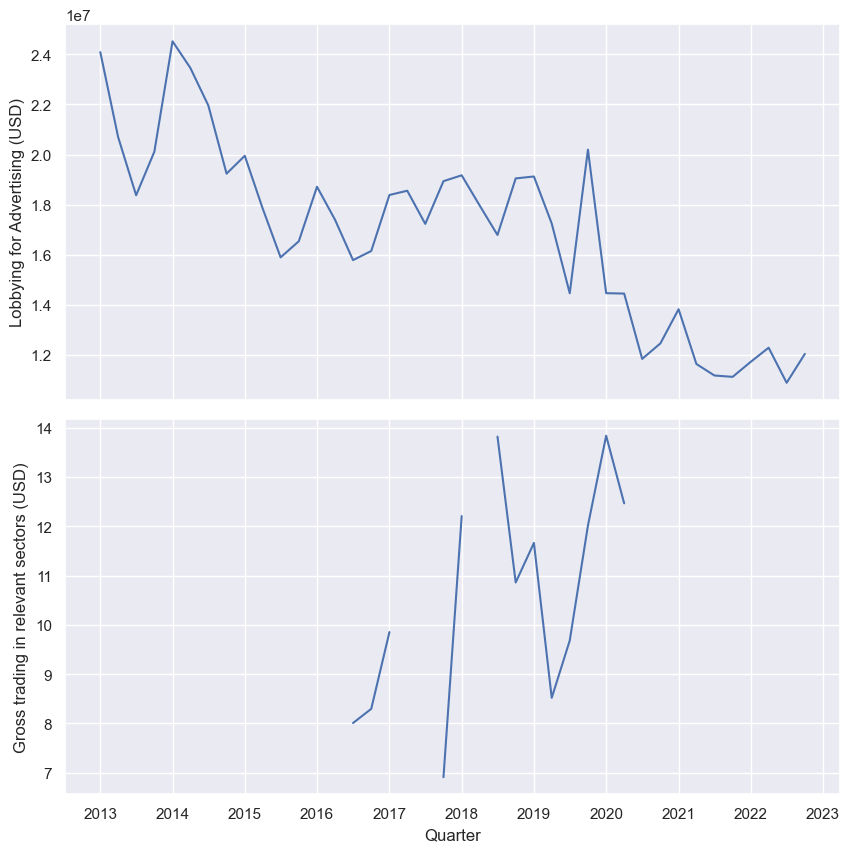

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


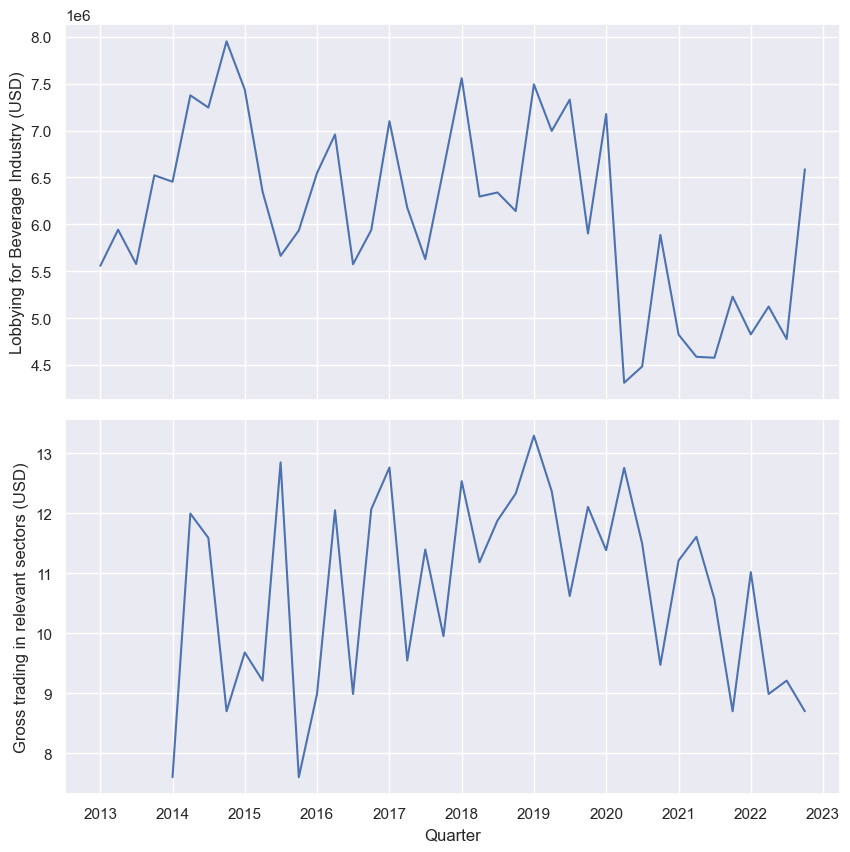

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


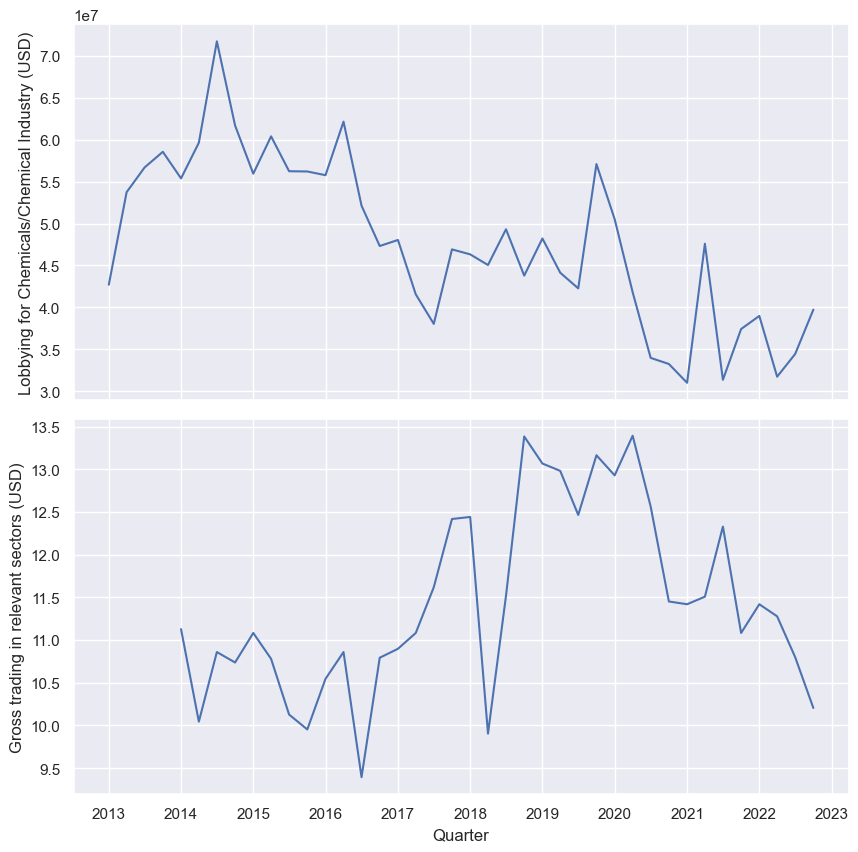

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


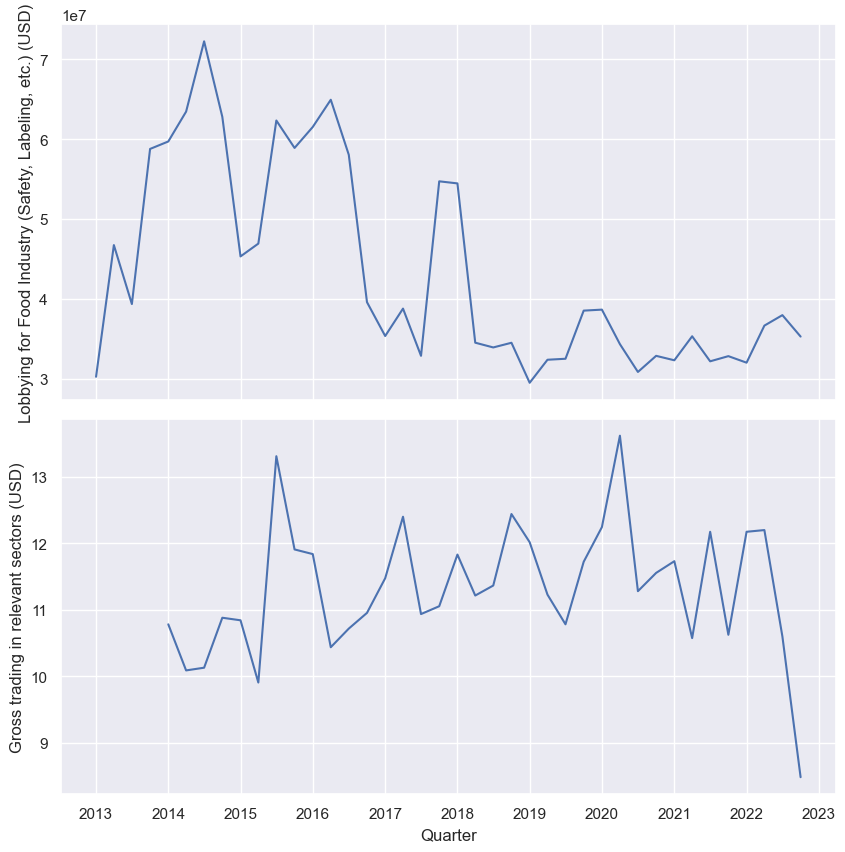

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


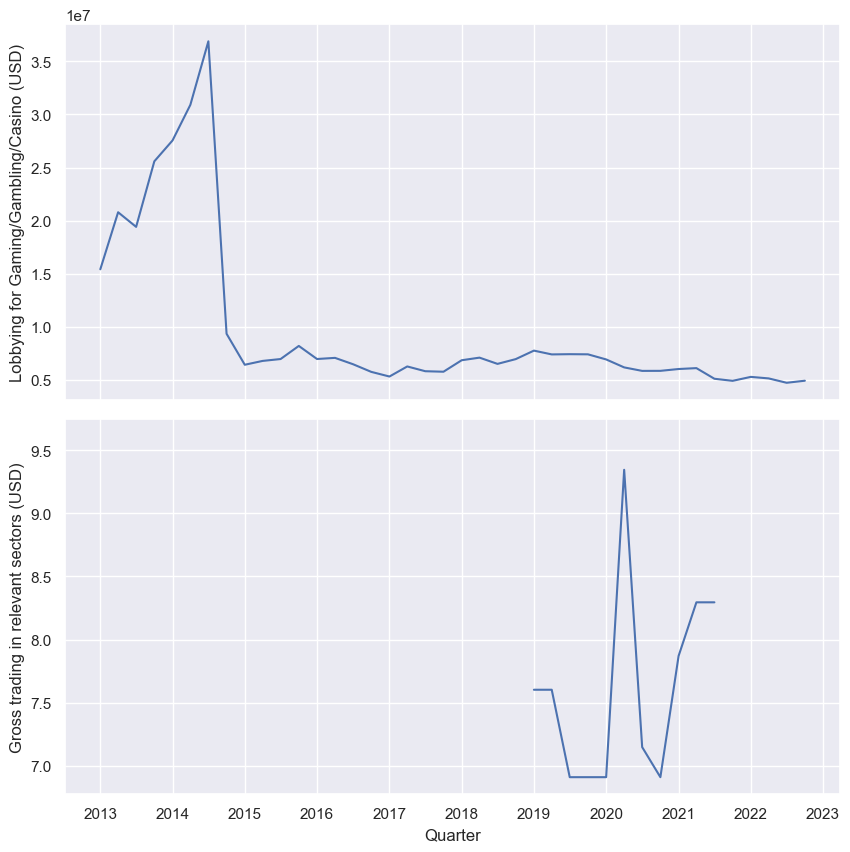

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


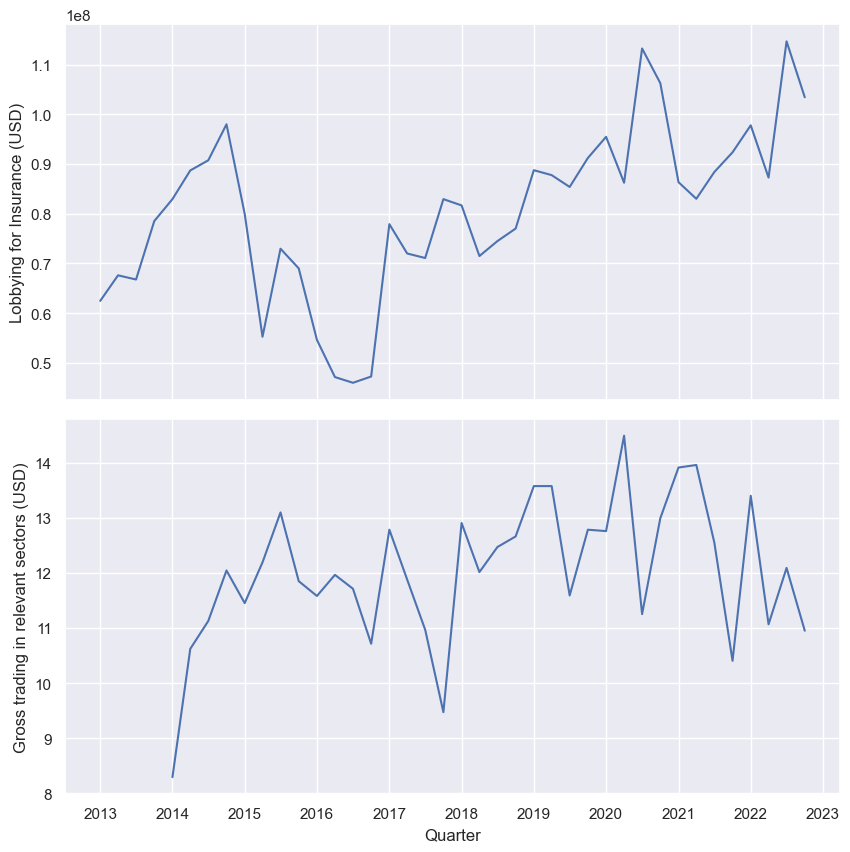

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


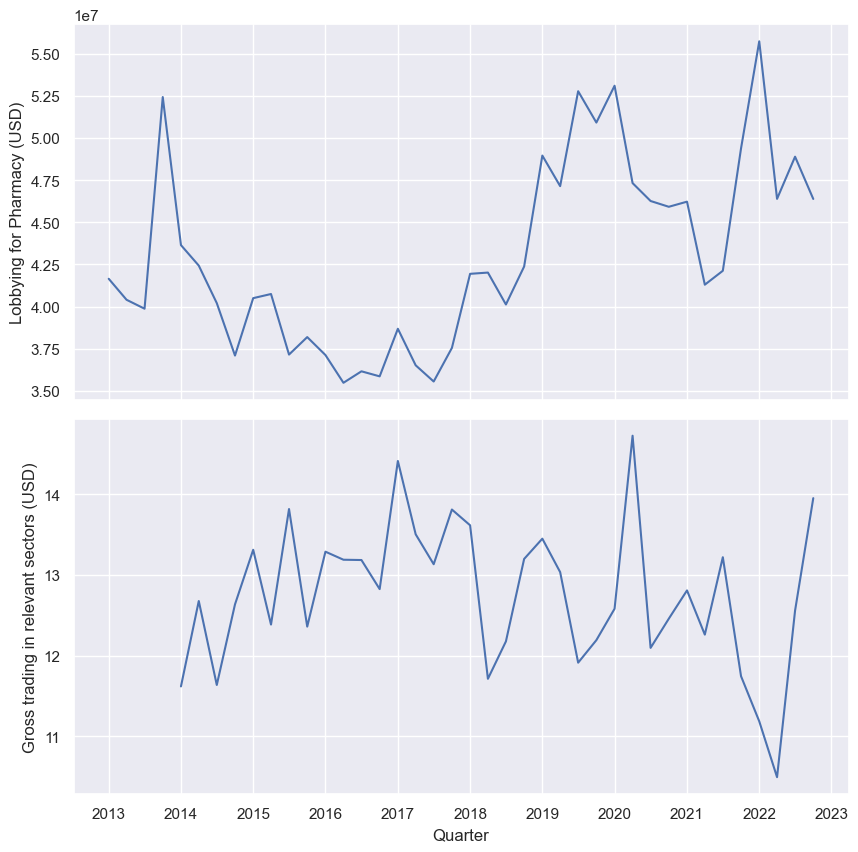

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


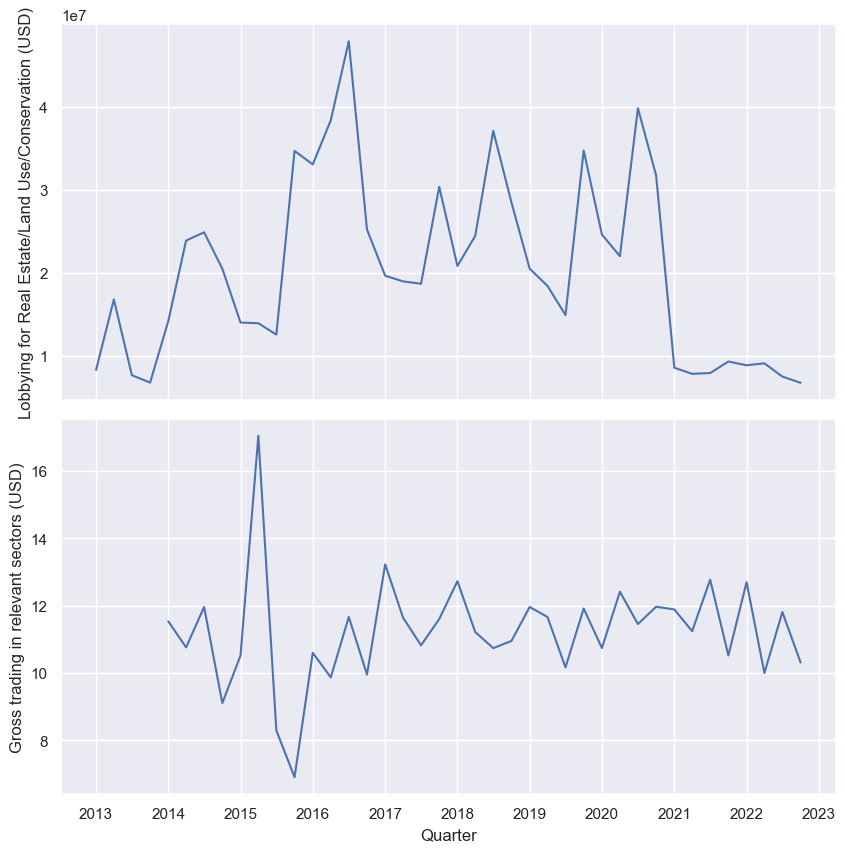

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


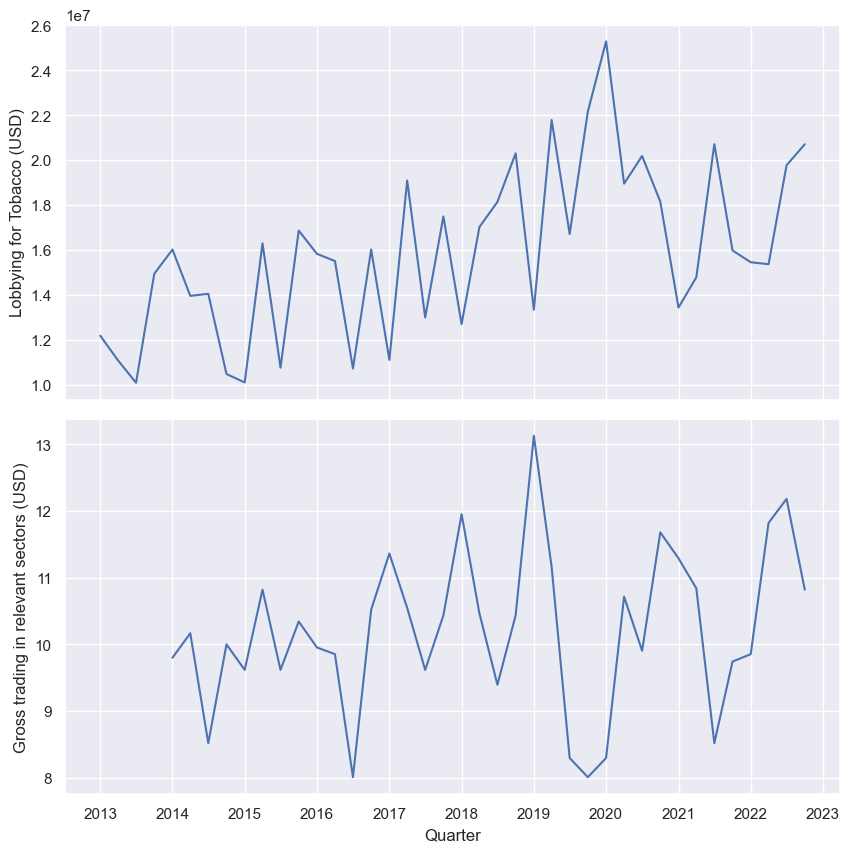

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


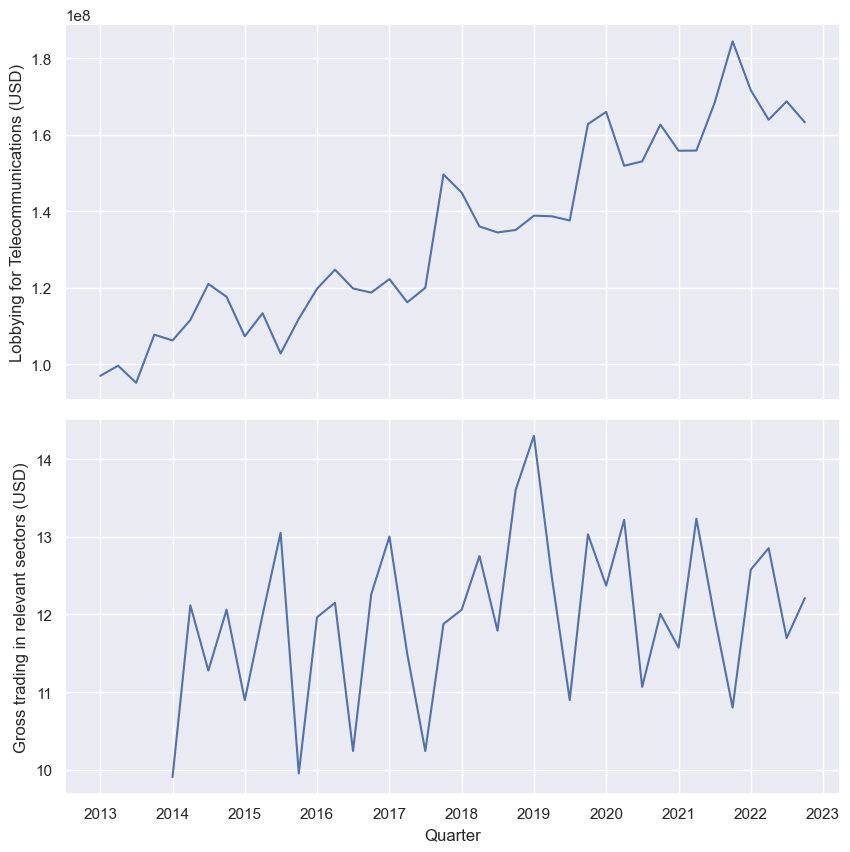

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


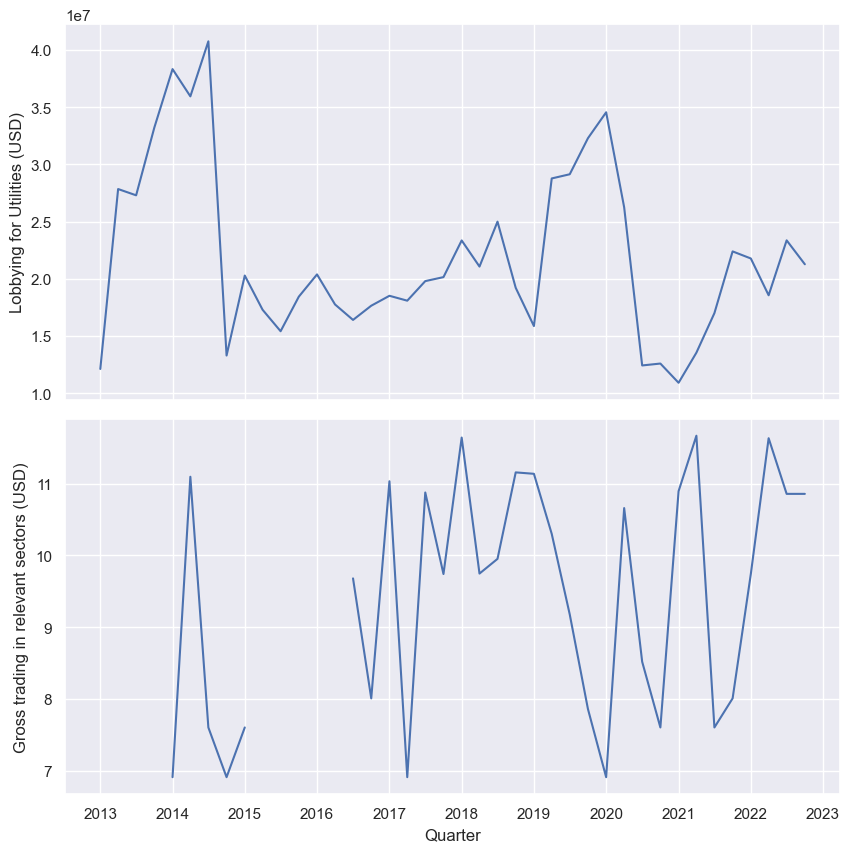

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


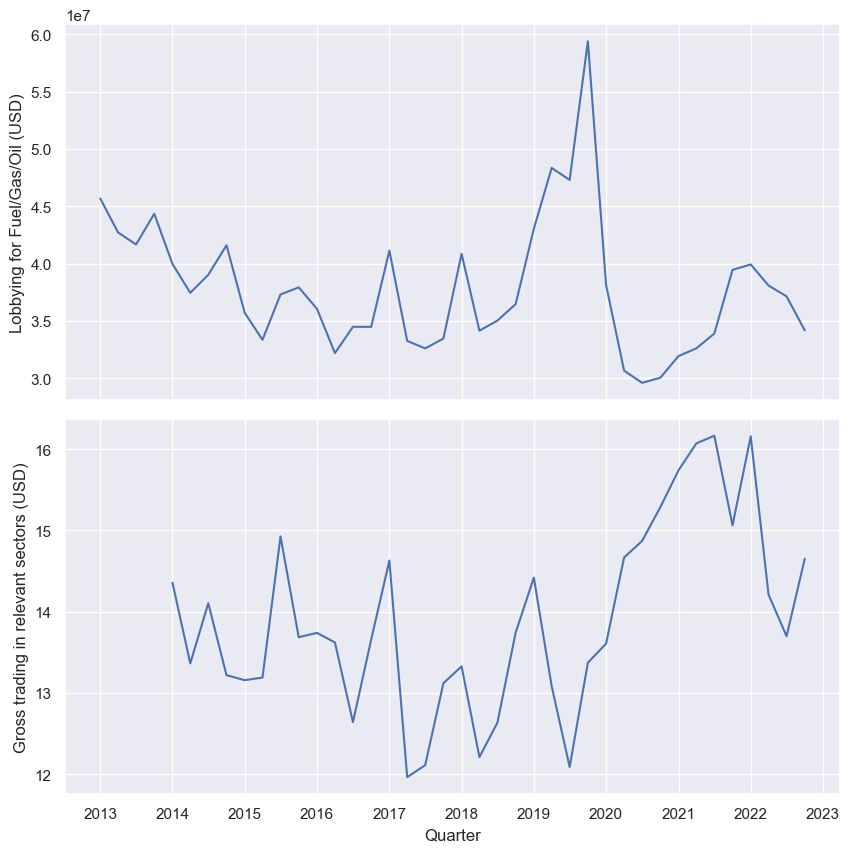

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


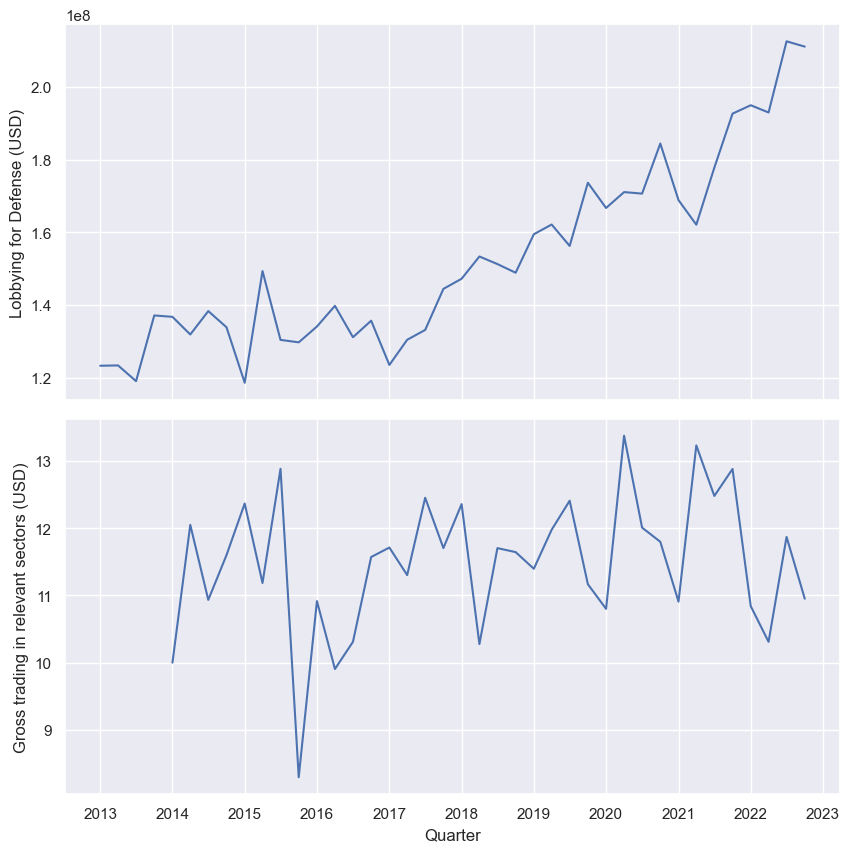

In [48]:
for key in list(cognates.keys()):
    totals= stock_and_lobbying_totals(key, cognates[key])
    fig, axs = plt.subplots(2  , 1, sharex=True, figsize=(10,10))
# Remove vertical space between axes
    fig.subplots_adjust(hspace=.05)
    axs[0].plot(totals.index,totals.lobbying_total )
    axs[0].set_ylabel("Lobbying for " + issue_codes[key] +" (USD)")
    axs[1].plot(totals.index, totals.stocks_gross)
    axs[1].set_ylabel("Gross trading in relevant sectors (USD)")
    axs[1].set_xlabel("Quarter")
    plt.show()

Let's look at some autocorrelations and correlations.

In [31]:
import statsmodels.api as sm

#### Autocorrelations

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


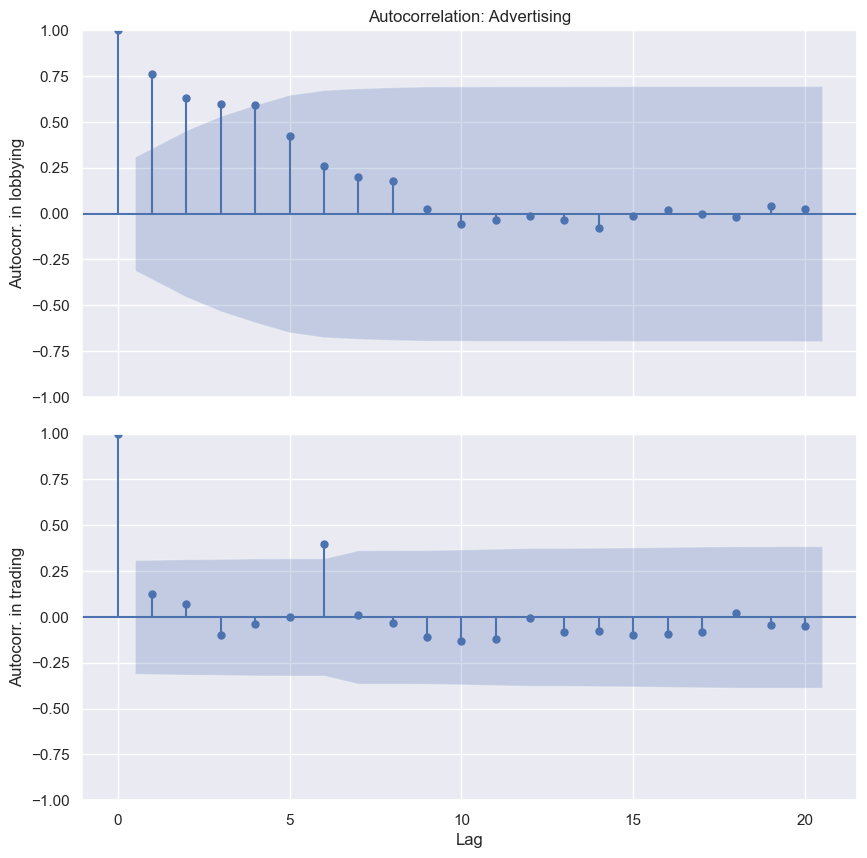

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


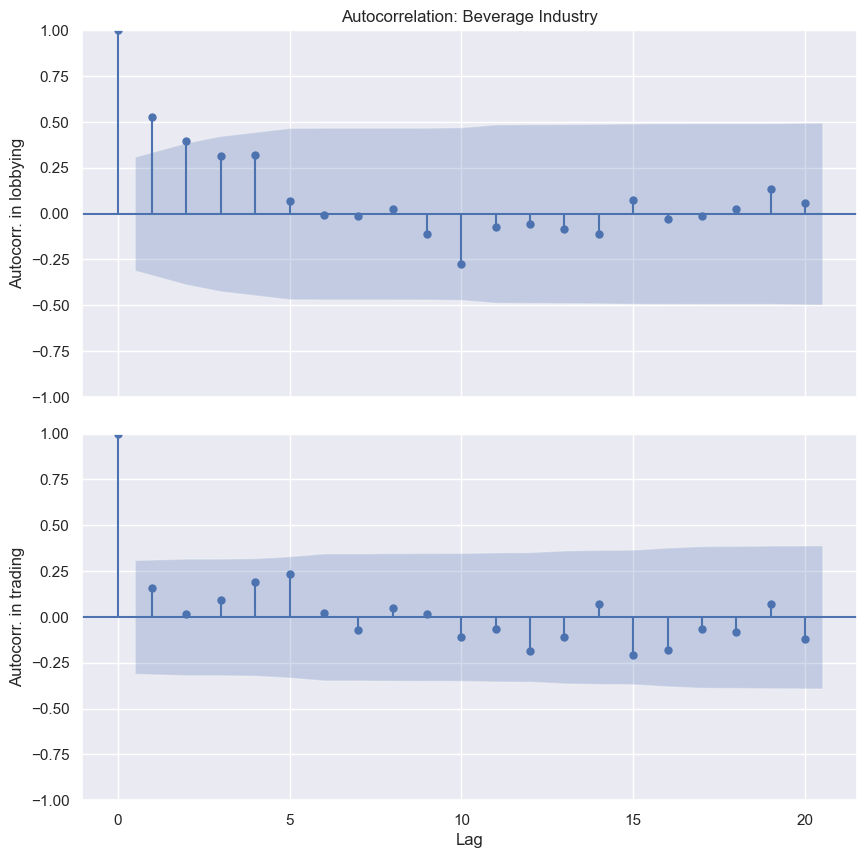

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


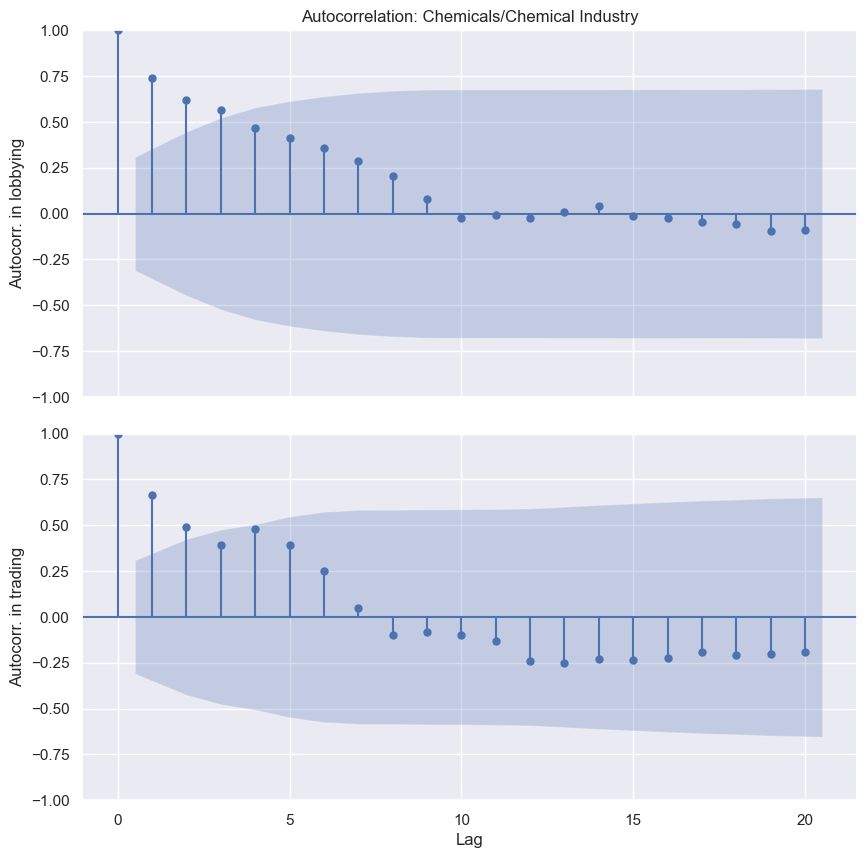

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


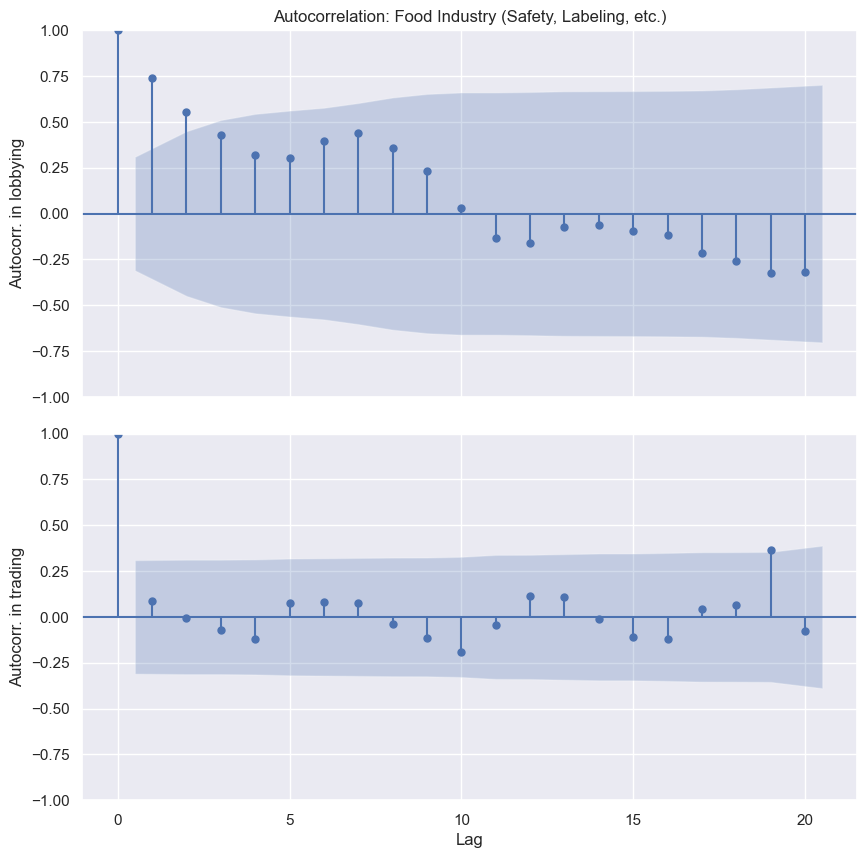

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


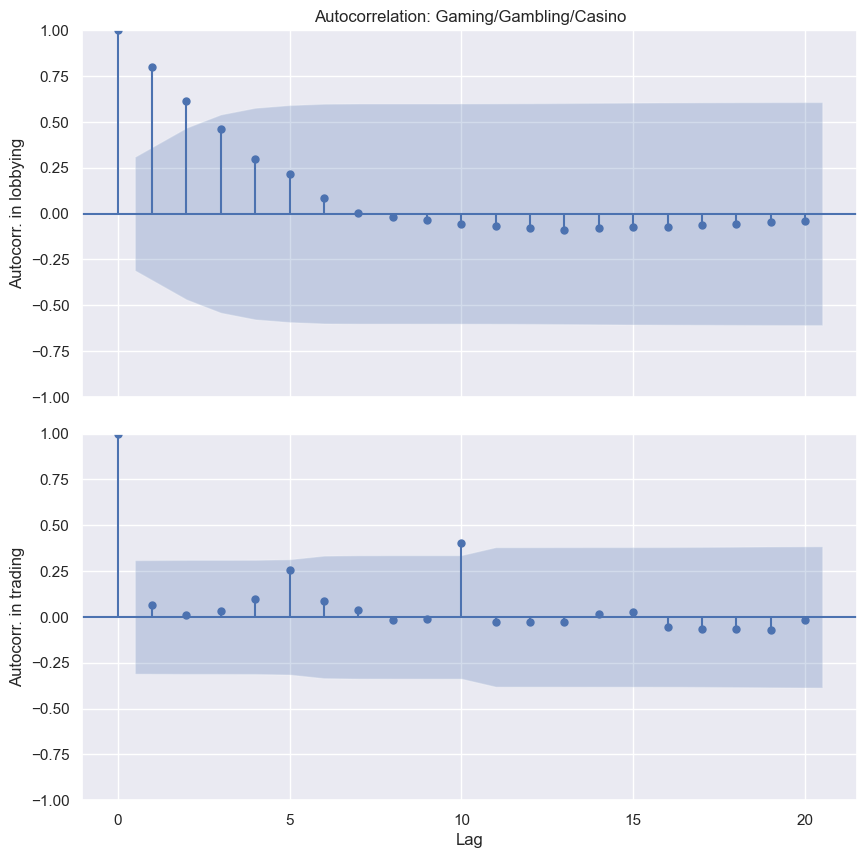

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


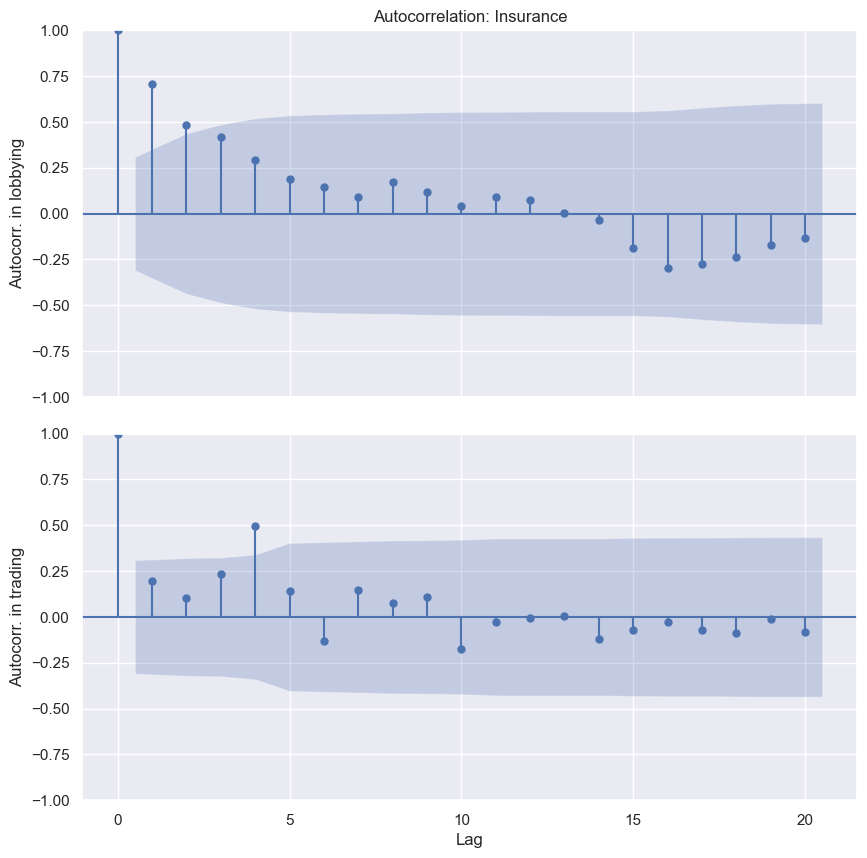

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


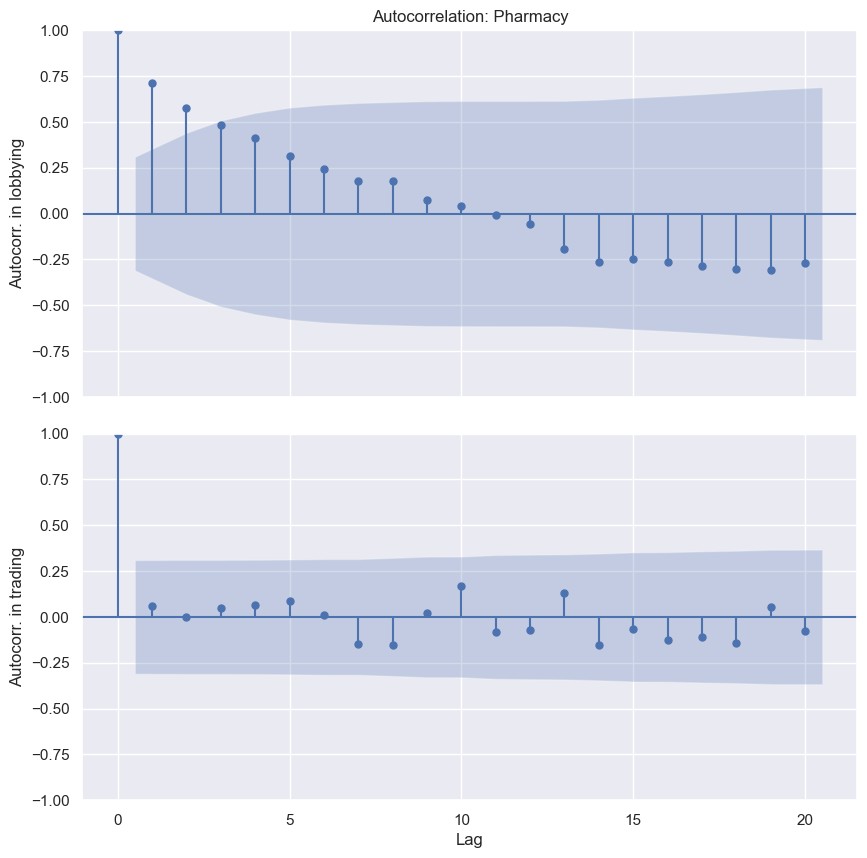

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


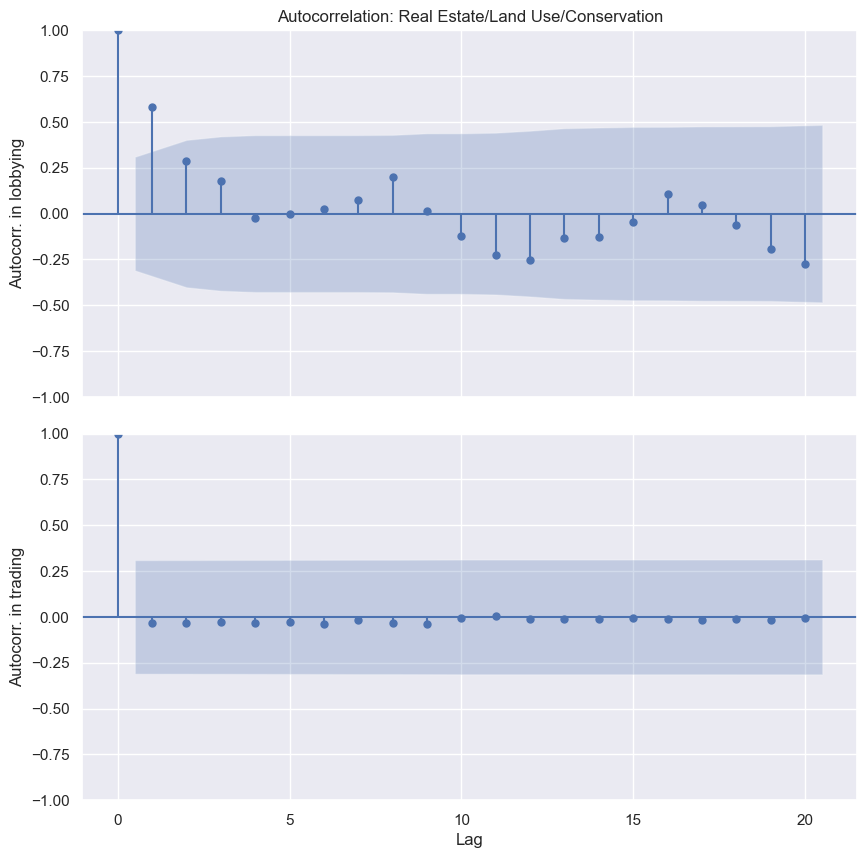

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


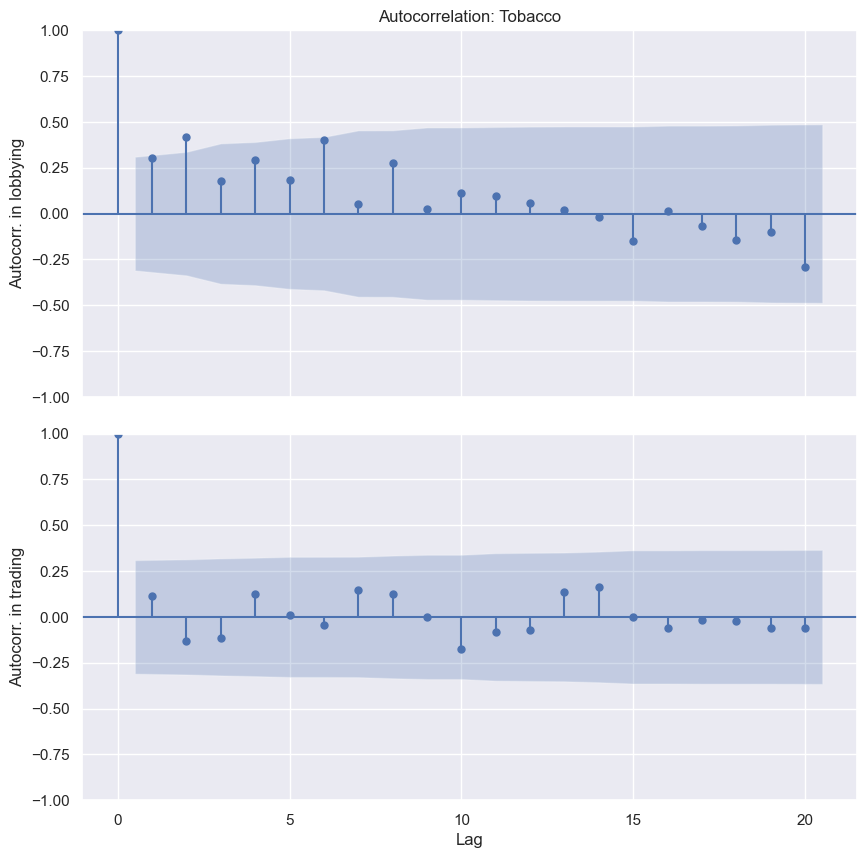

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


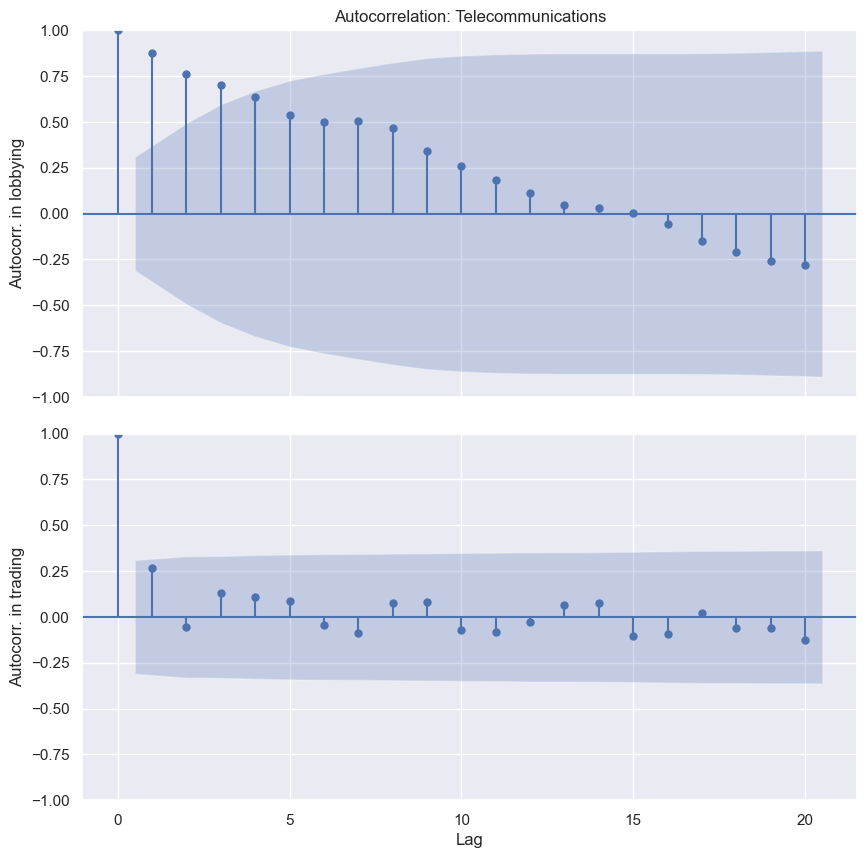

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


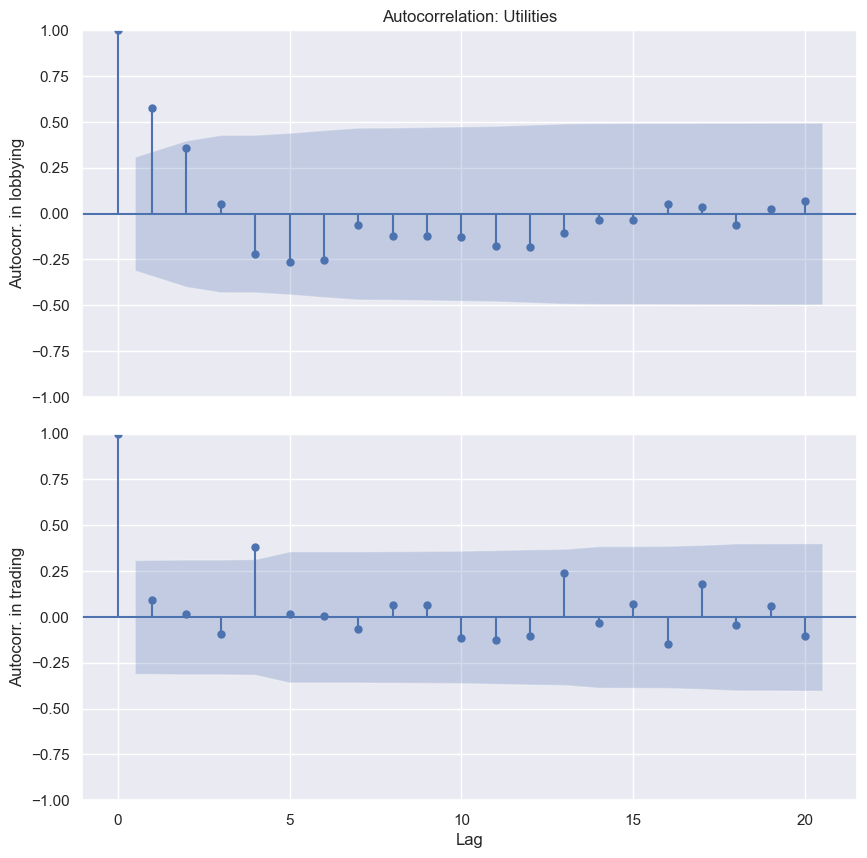

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


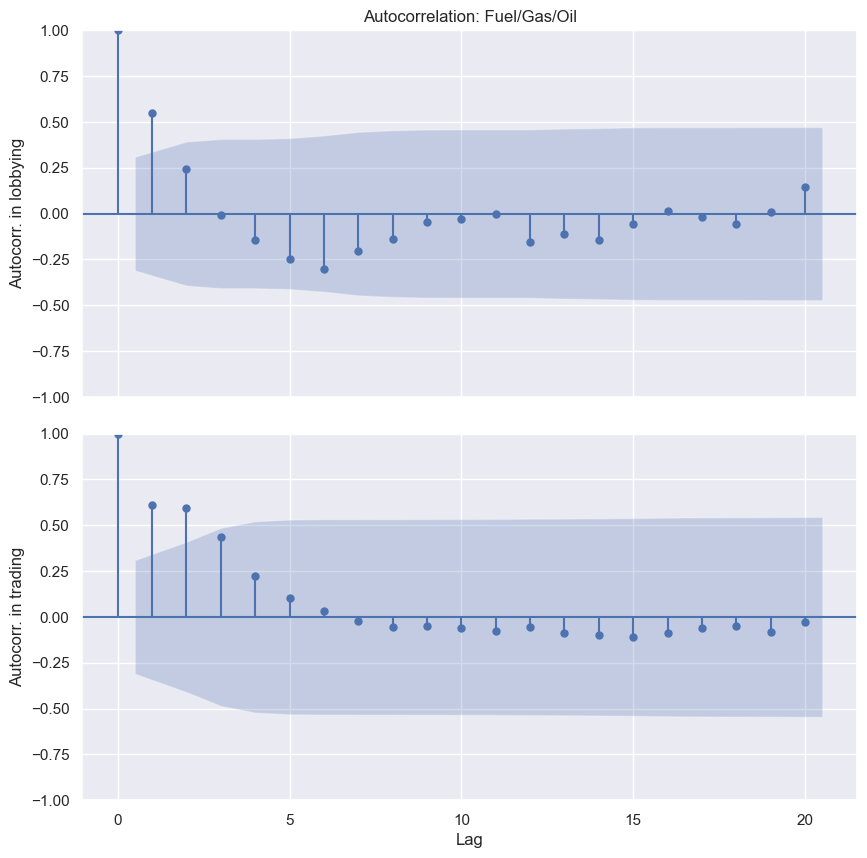

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


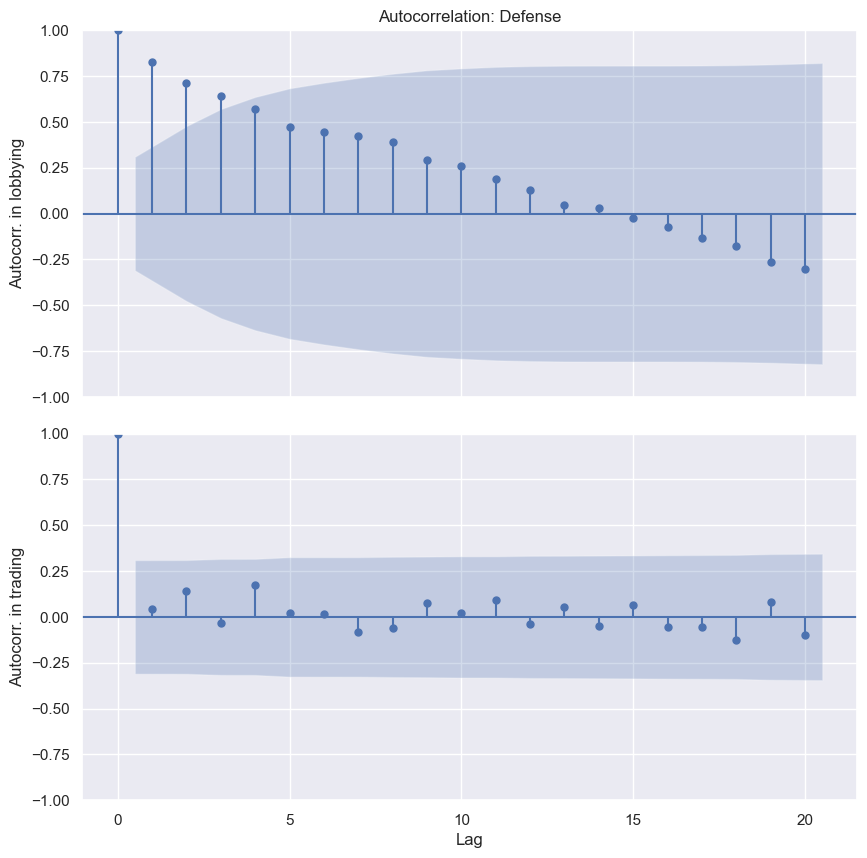

In [46]:
for key in list(cognates.keys()):
    totals= stock_and_lobbying_totals(key, cognates[key])
    fig, axs = plt.subplots(2  , 1, sharex=True, figsize=(10,10))
    fig.subplots_adjust(hspace=.1)
    sm.graphics.tsa.plot_acf(totals.lobbying_total, lags = 20, ax=axs[0], title='Autocorrelation: '+issue_codes[key])
    axs[0].set_ylabel("Autocorr. in lobbying")
    sm.graphics.tsa.plot_acf(totals.stocks_gross, lags = 20, ax=axs[1], title=None)
    axs[1].set_ylabel("Autocorr. in trading")
    axs[1].set_xlabel("Lag")
    plt.show()
    

    

#### Partial autocorrelations

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


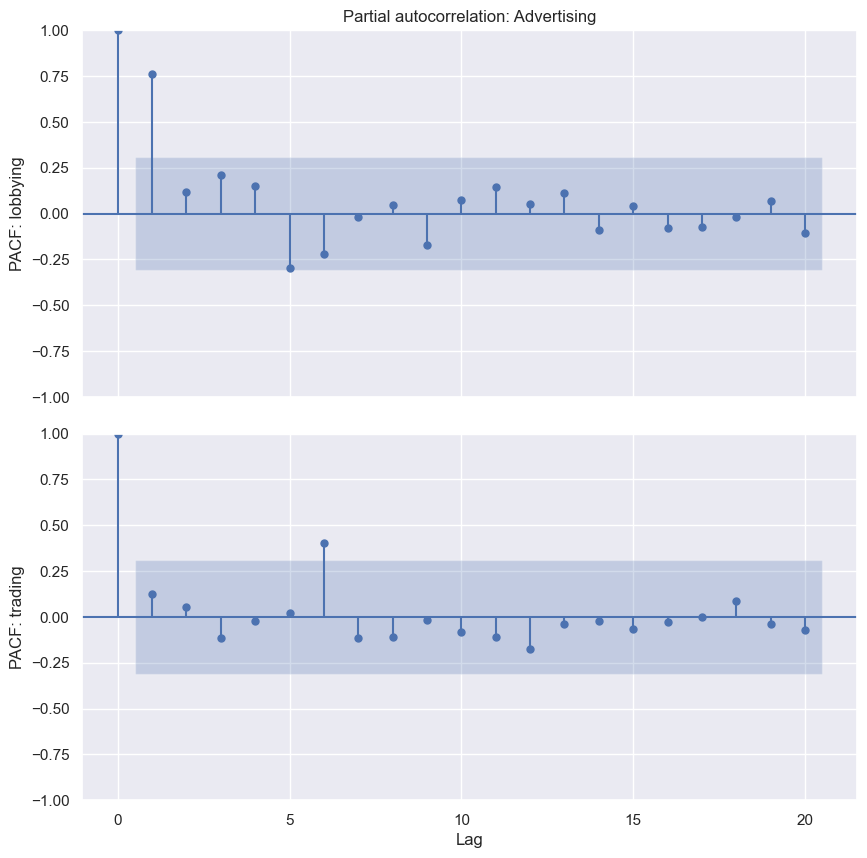

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


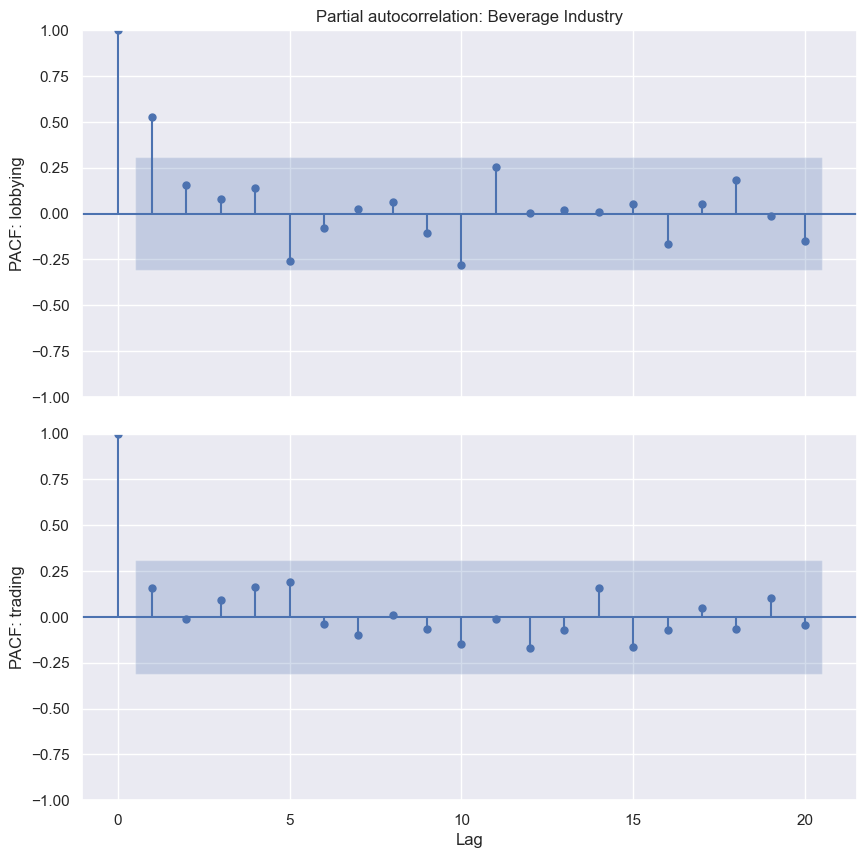

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


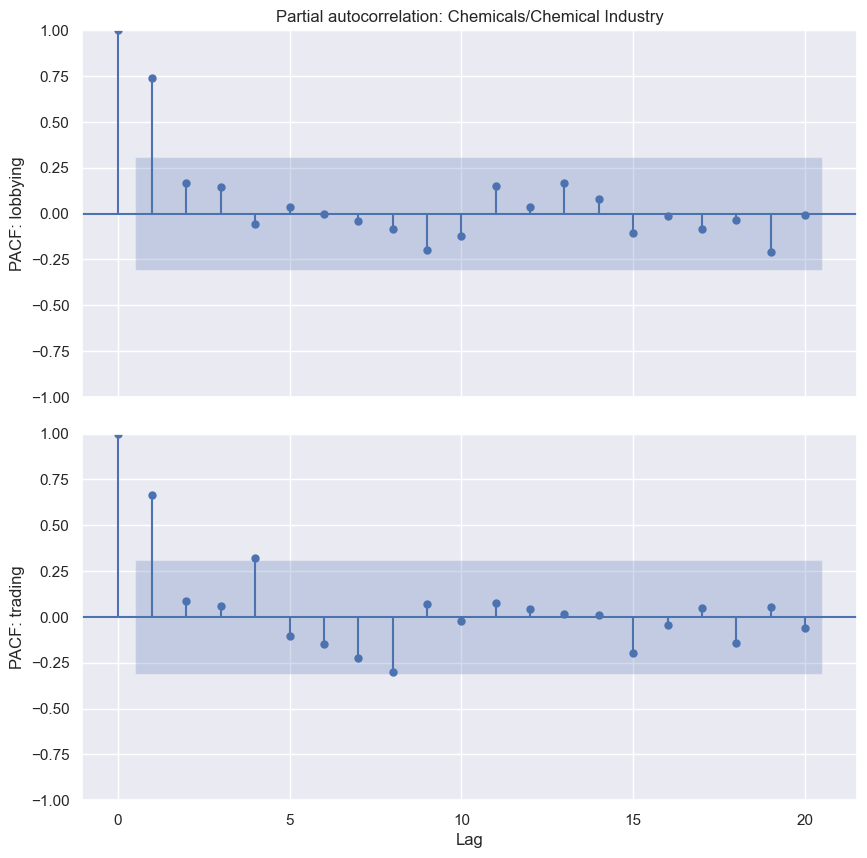

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


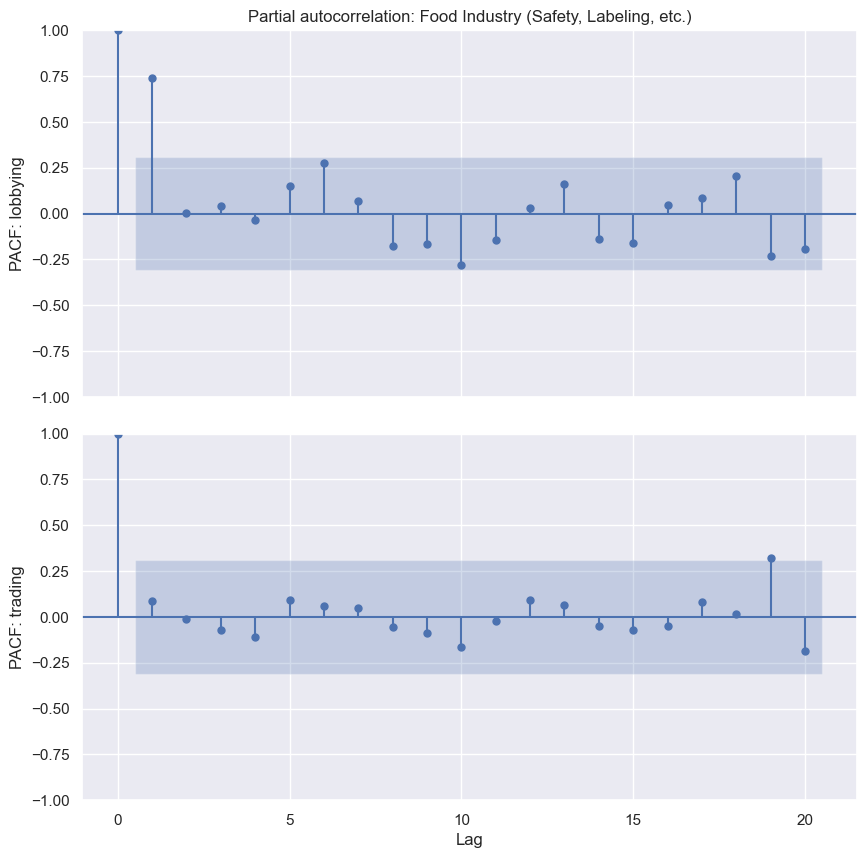

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


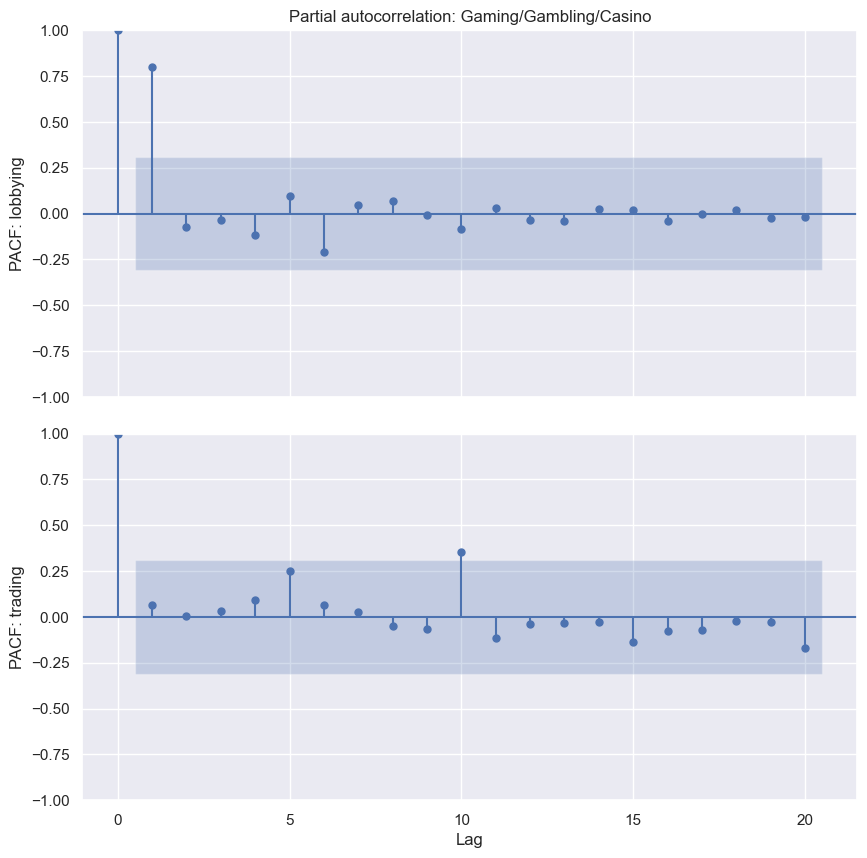

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


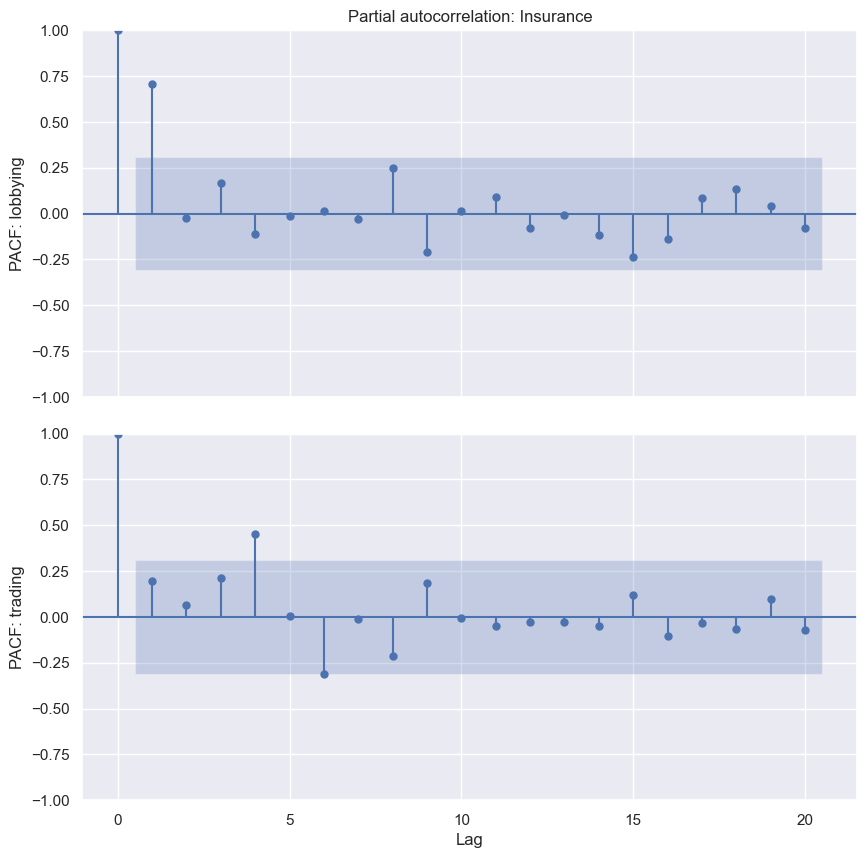

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


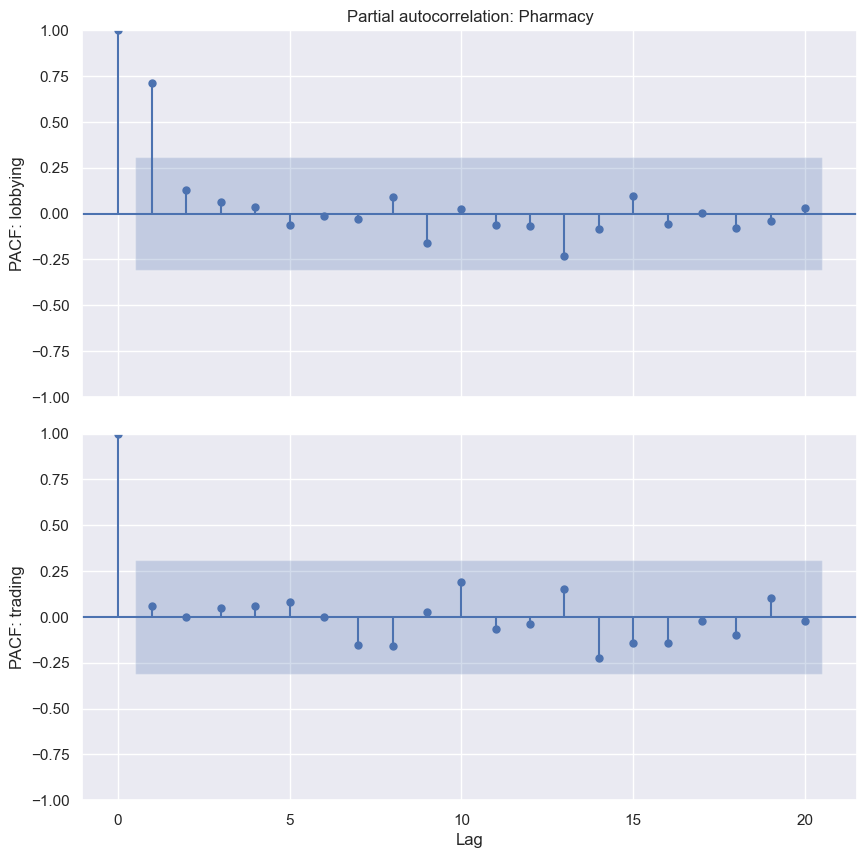

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


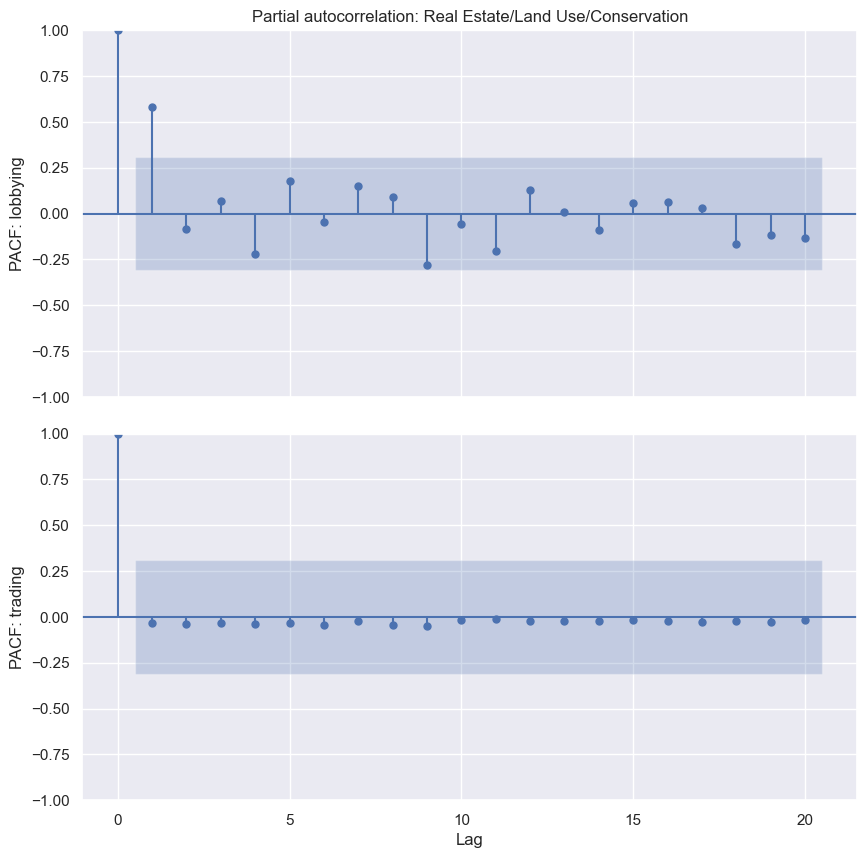

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


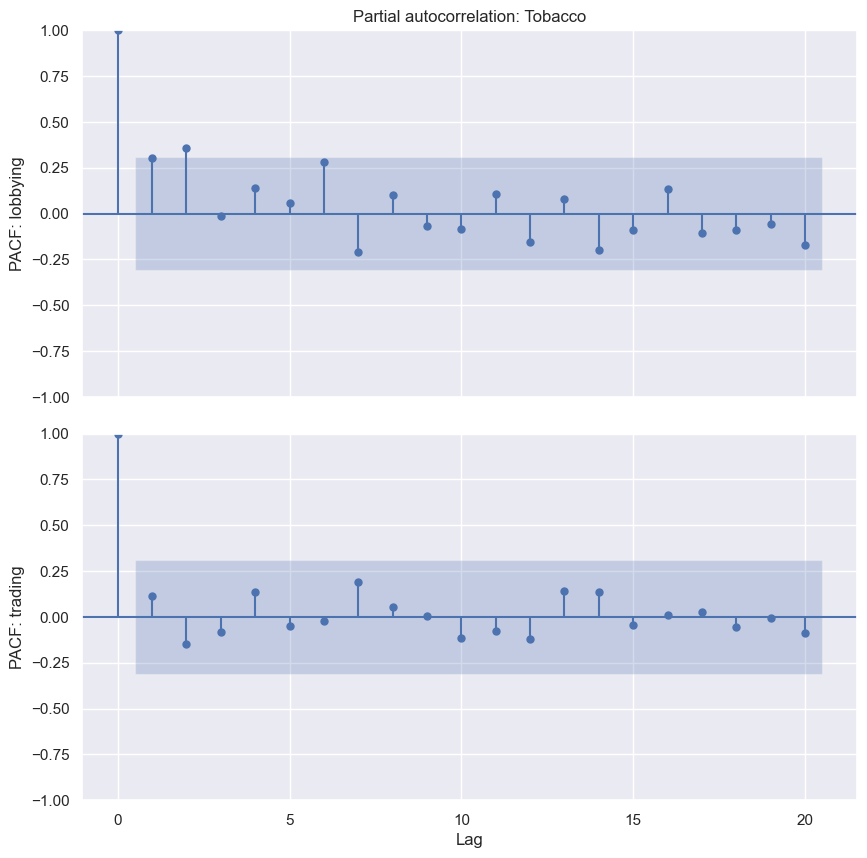

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


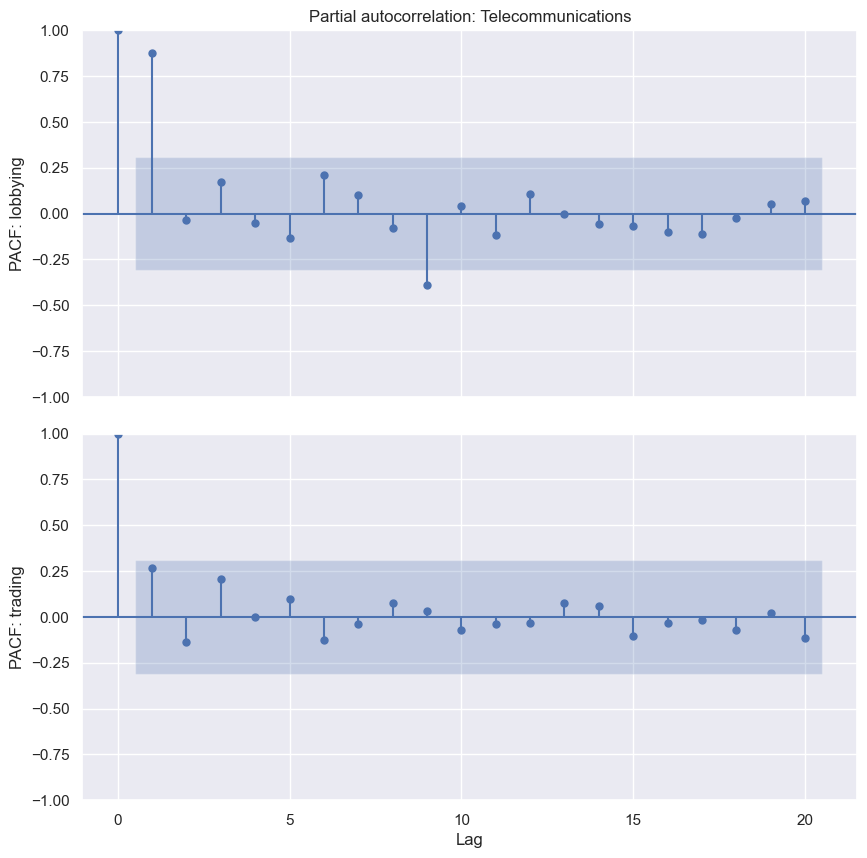

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


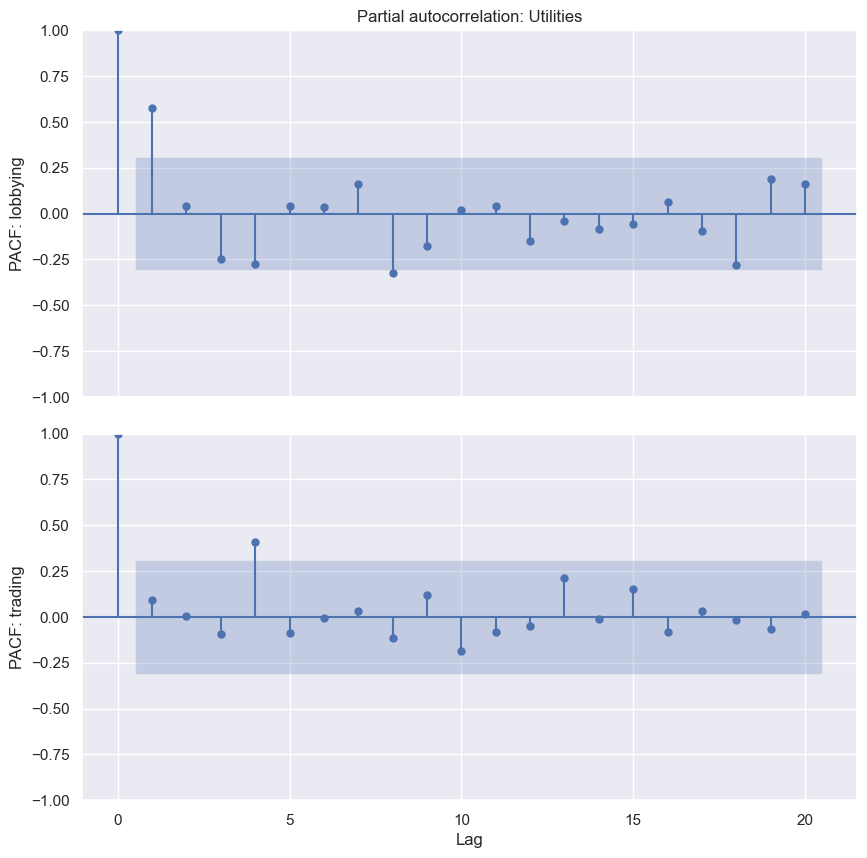

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


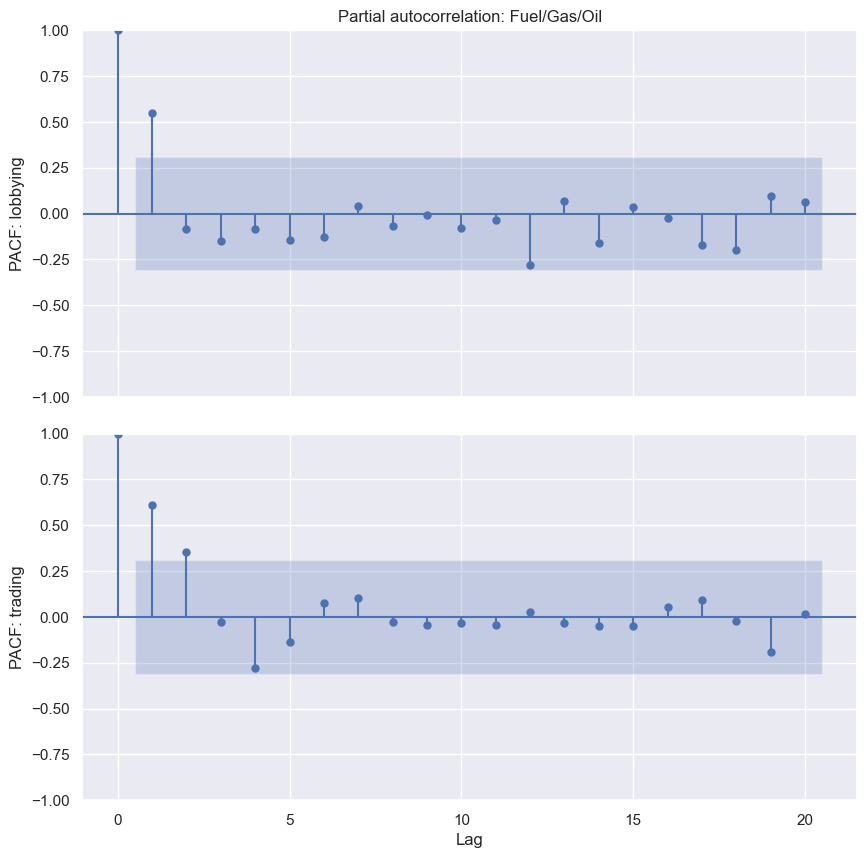

/Users/yinishi/workspace/github_rahul/pred-pol-trading-lobbying/scripts/data_extraction.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stocks = pd.read_csv(TRADING_PATH / "stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])


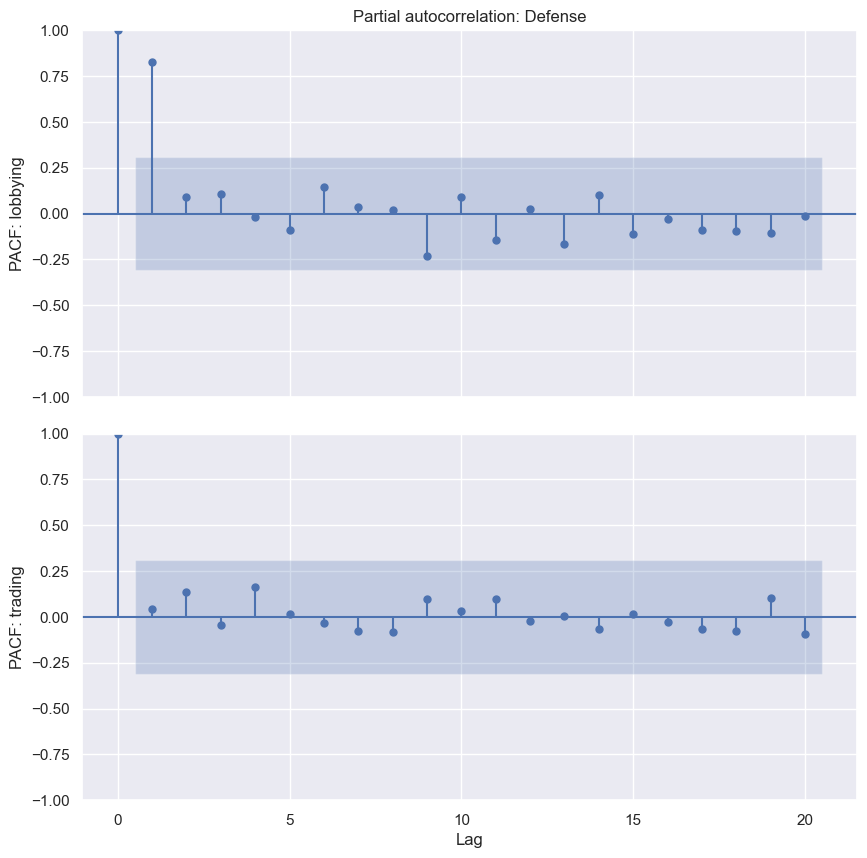

In [47]:
for key in list(cognates.keys()):
    totals= stock_and_lobbying_totals(key, cognates[key])
    fig, axs = plt.subplots(2  , 1, sharex=True, figsize=(10,10))
    fig.subplots_adjust(hspace=.1)
    sm.graphics.tsa.plot_pacf(totals.lobbying_total, lags = 20, ax=axs[0], title='Partial autocorrelation: '+issue_codes[key])
    axs[0].set_ylabel("PACF: lobbying")
    sm.graphics.tsa.plot_pacf(totals.stocks_gross, lags = 20, ax=axs[1], title=None)
    axs[1].set_ylabel("PACF: trading")
    axs[1].set_xlabel("Lag")
    plt.show()